In [ ]:
!pip install yfinance
!pip install quandl
!pip install fbprophet
!pip install cpi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 6.4 MB 50.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in index

In [ ]:
import pandas as pd
import yfinance as yf  
import numpy as np
import quandl
import matplotlib.pyplot as plt


QUANDL_KEY = 'mYEW7smzJx_ukvwEwDFa'
quandl.ApiConfig.api_key = QUANDL_KEY

from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = quandl.get(dataset = 'WGC/GOLD_MONAVG_USD', start_date = '2000-01-01', end_date = '2011-12-31')
df.rename(columns = {'Value':'price'}, inplace = True)

df = df.resample('M').last()
df

,price
Date,
2000-01-31,284.31
2000-02-29,299.86
2000-03-31,286.39
2000-04-30,279.69
2000-05-31,275.19
...,...
2011-08-31,1755.81
2011-09-30,1771.85
2011-10-31,1665.21


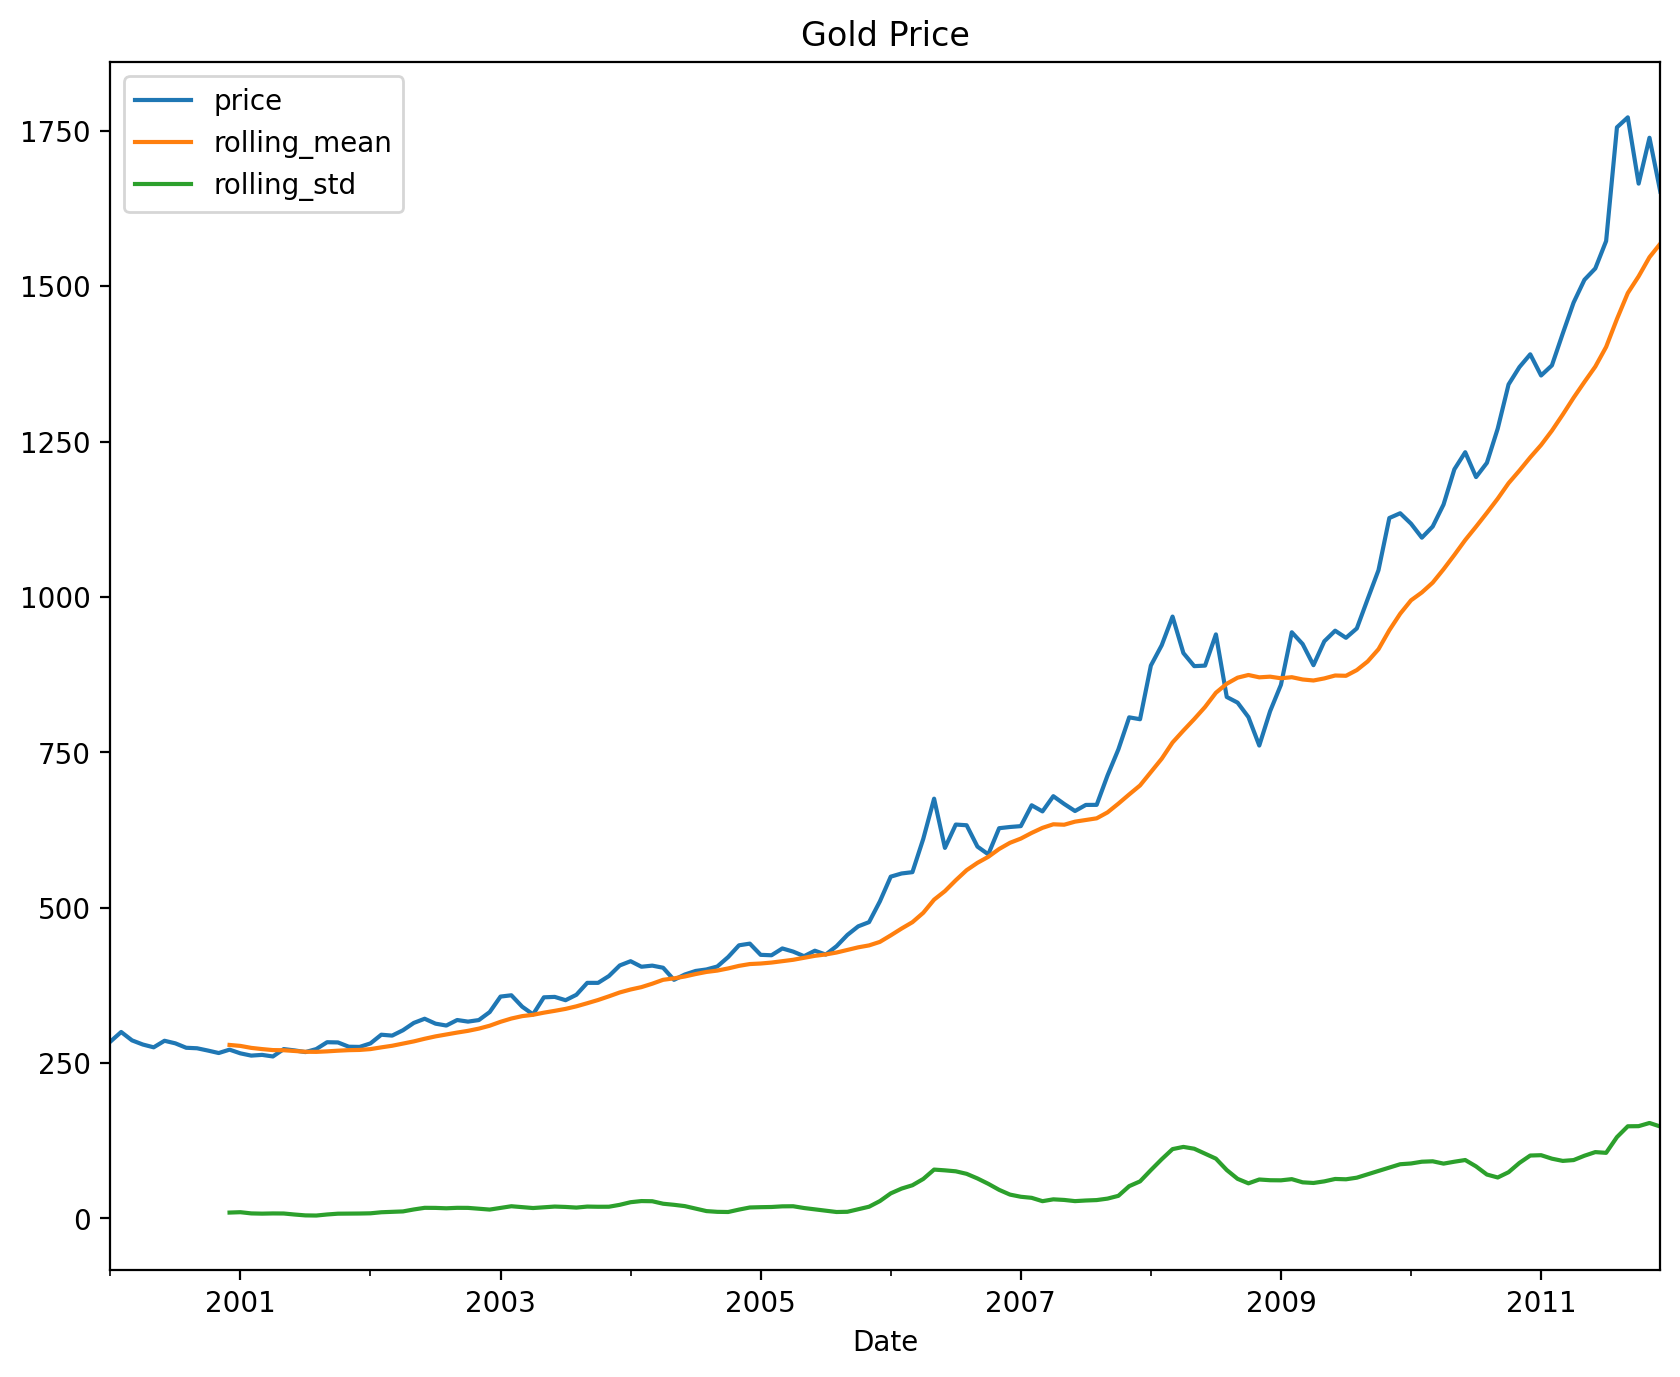

In [ ]:
window_size = 12
df['rolling_mean'] = df.price.rolling(window = window_size).mean()
df['rolling_std']  = df.price.rolling(window = window_size).std()

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize']=[10, 8]
plt.rcParams['figure.dpi']=200

df.plot(title = 'Gold Price')

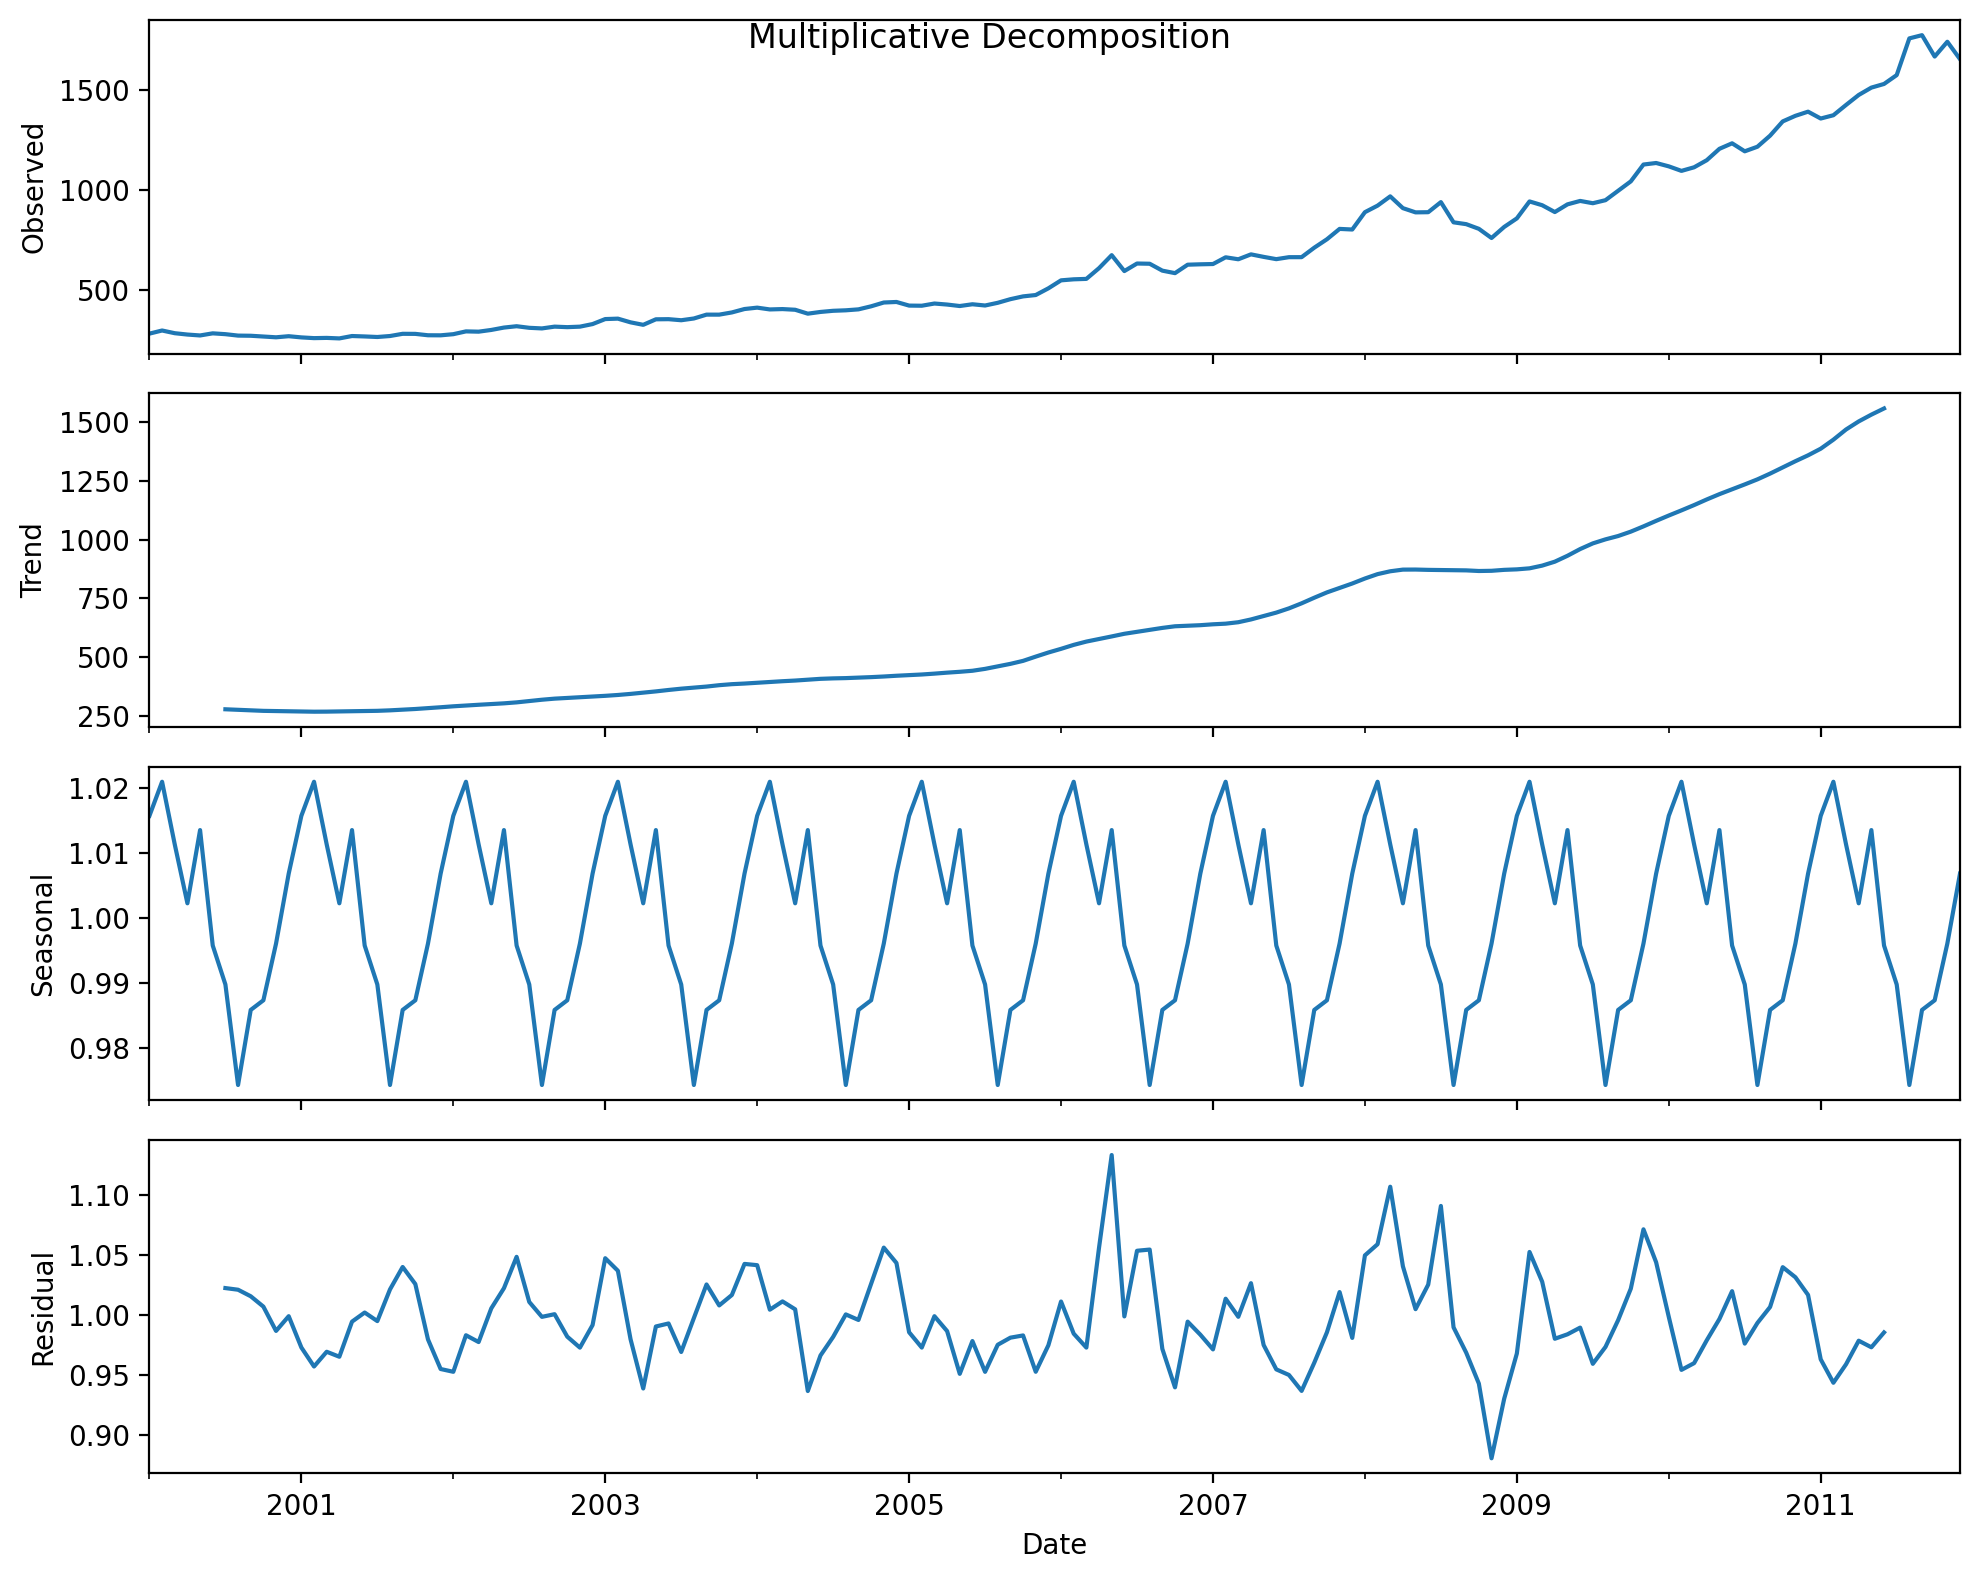

In [ ]:
decomposition_results = seasonal_decompose(df.price, model = 'multiplicative')
print(decomposition_results)
decomposition_results.plot().suptitle('Multiplicative Decomposition');

In [ ]:
import seaborn as sns
import fbprophet as Prophet

In [ ]:
df = quandl.get(dataset = 'WGC/GOLD_DAILY_USD', start_date = '2000-01-01', end_date = '2005-12-31')
df.reset_index(drop = False, inplace =True)

df.rename(columns = {'Date':'ds', 'Value':'y'}, inplace = True)

df

,ds,y
0,2000-01-03,290.25
1,2000-01-04,281.50
2,2000-01-05,280.45
3,2000-01-06,279.40
4,2000-01-07,282.10
...,...,...
1560,2005-12-26,500.00
1561,2005-12-27,500.00
1562,2005-12-28,518.00
1563,2005-12-29,513.00


In [ ]:
train_indices = df.ds.apply(lambda x:x.year) < 2005
df_train = df.loc[train_indices].dropna()
df_test = df.loc[~train_indices].reset_index(drop = True)


In [ ]:
model_prophet = Prophet.Prophet(seasonality_mode = 'additive')
model_prophet.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model_prophet.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


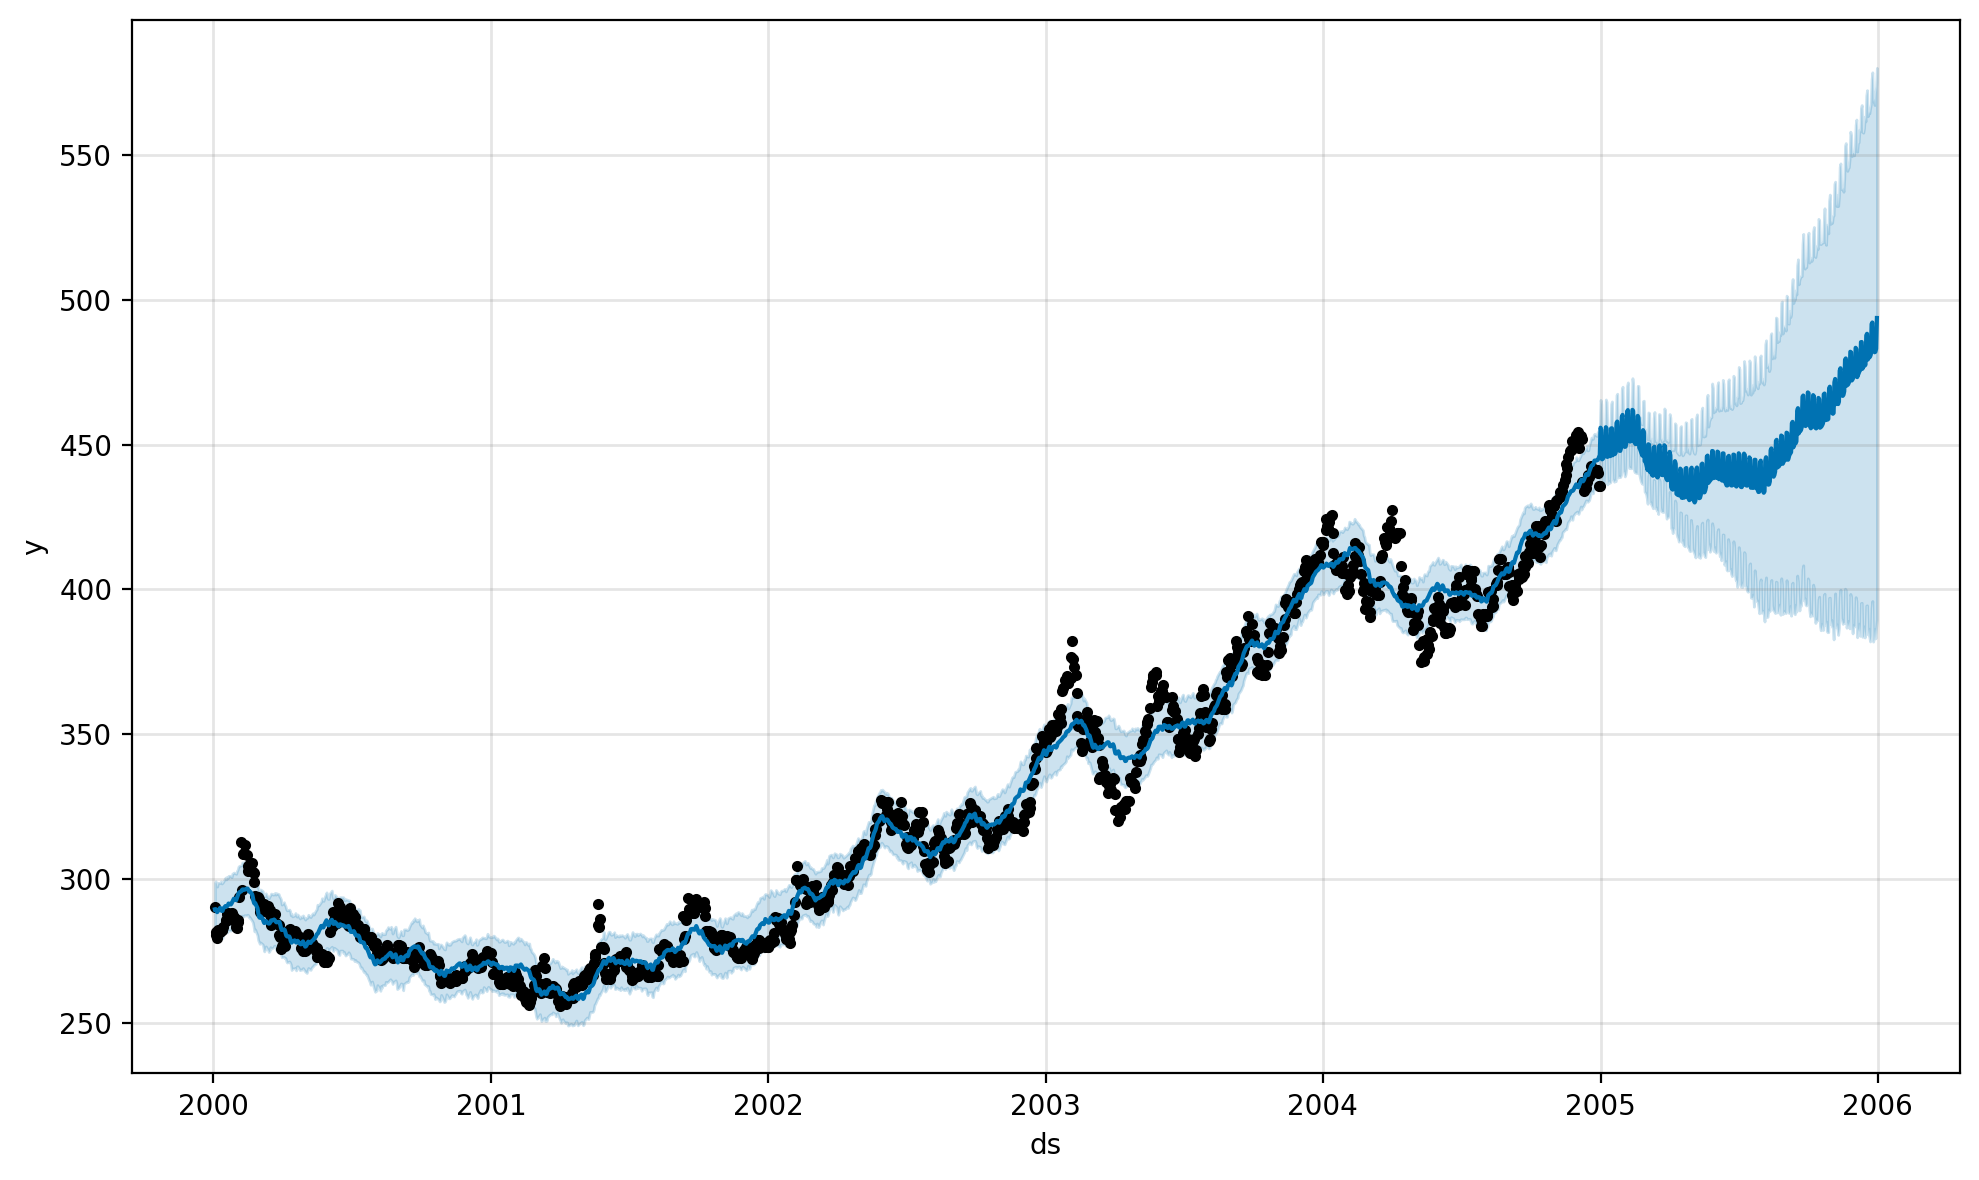

In [ ]:
df_future = model_prophet.make_future_dataframe(periods = 365)
df_pred = model_prophet.predict(df_future)
predictive_plot = model_prophet.plot(df_pred)

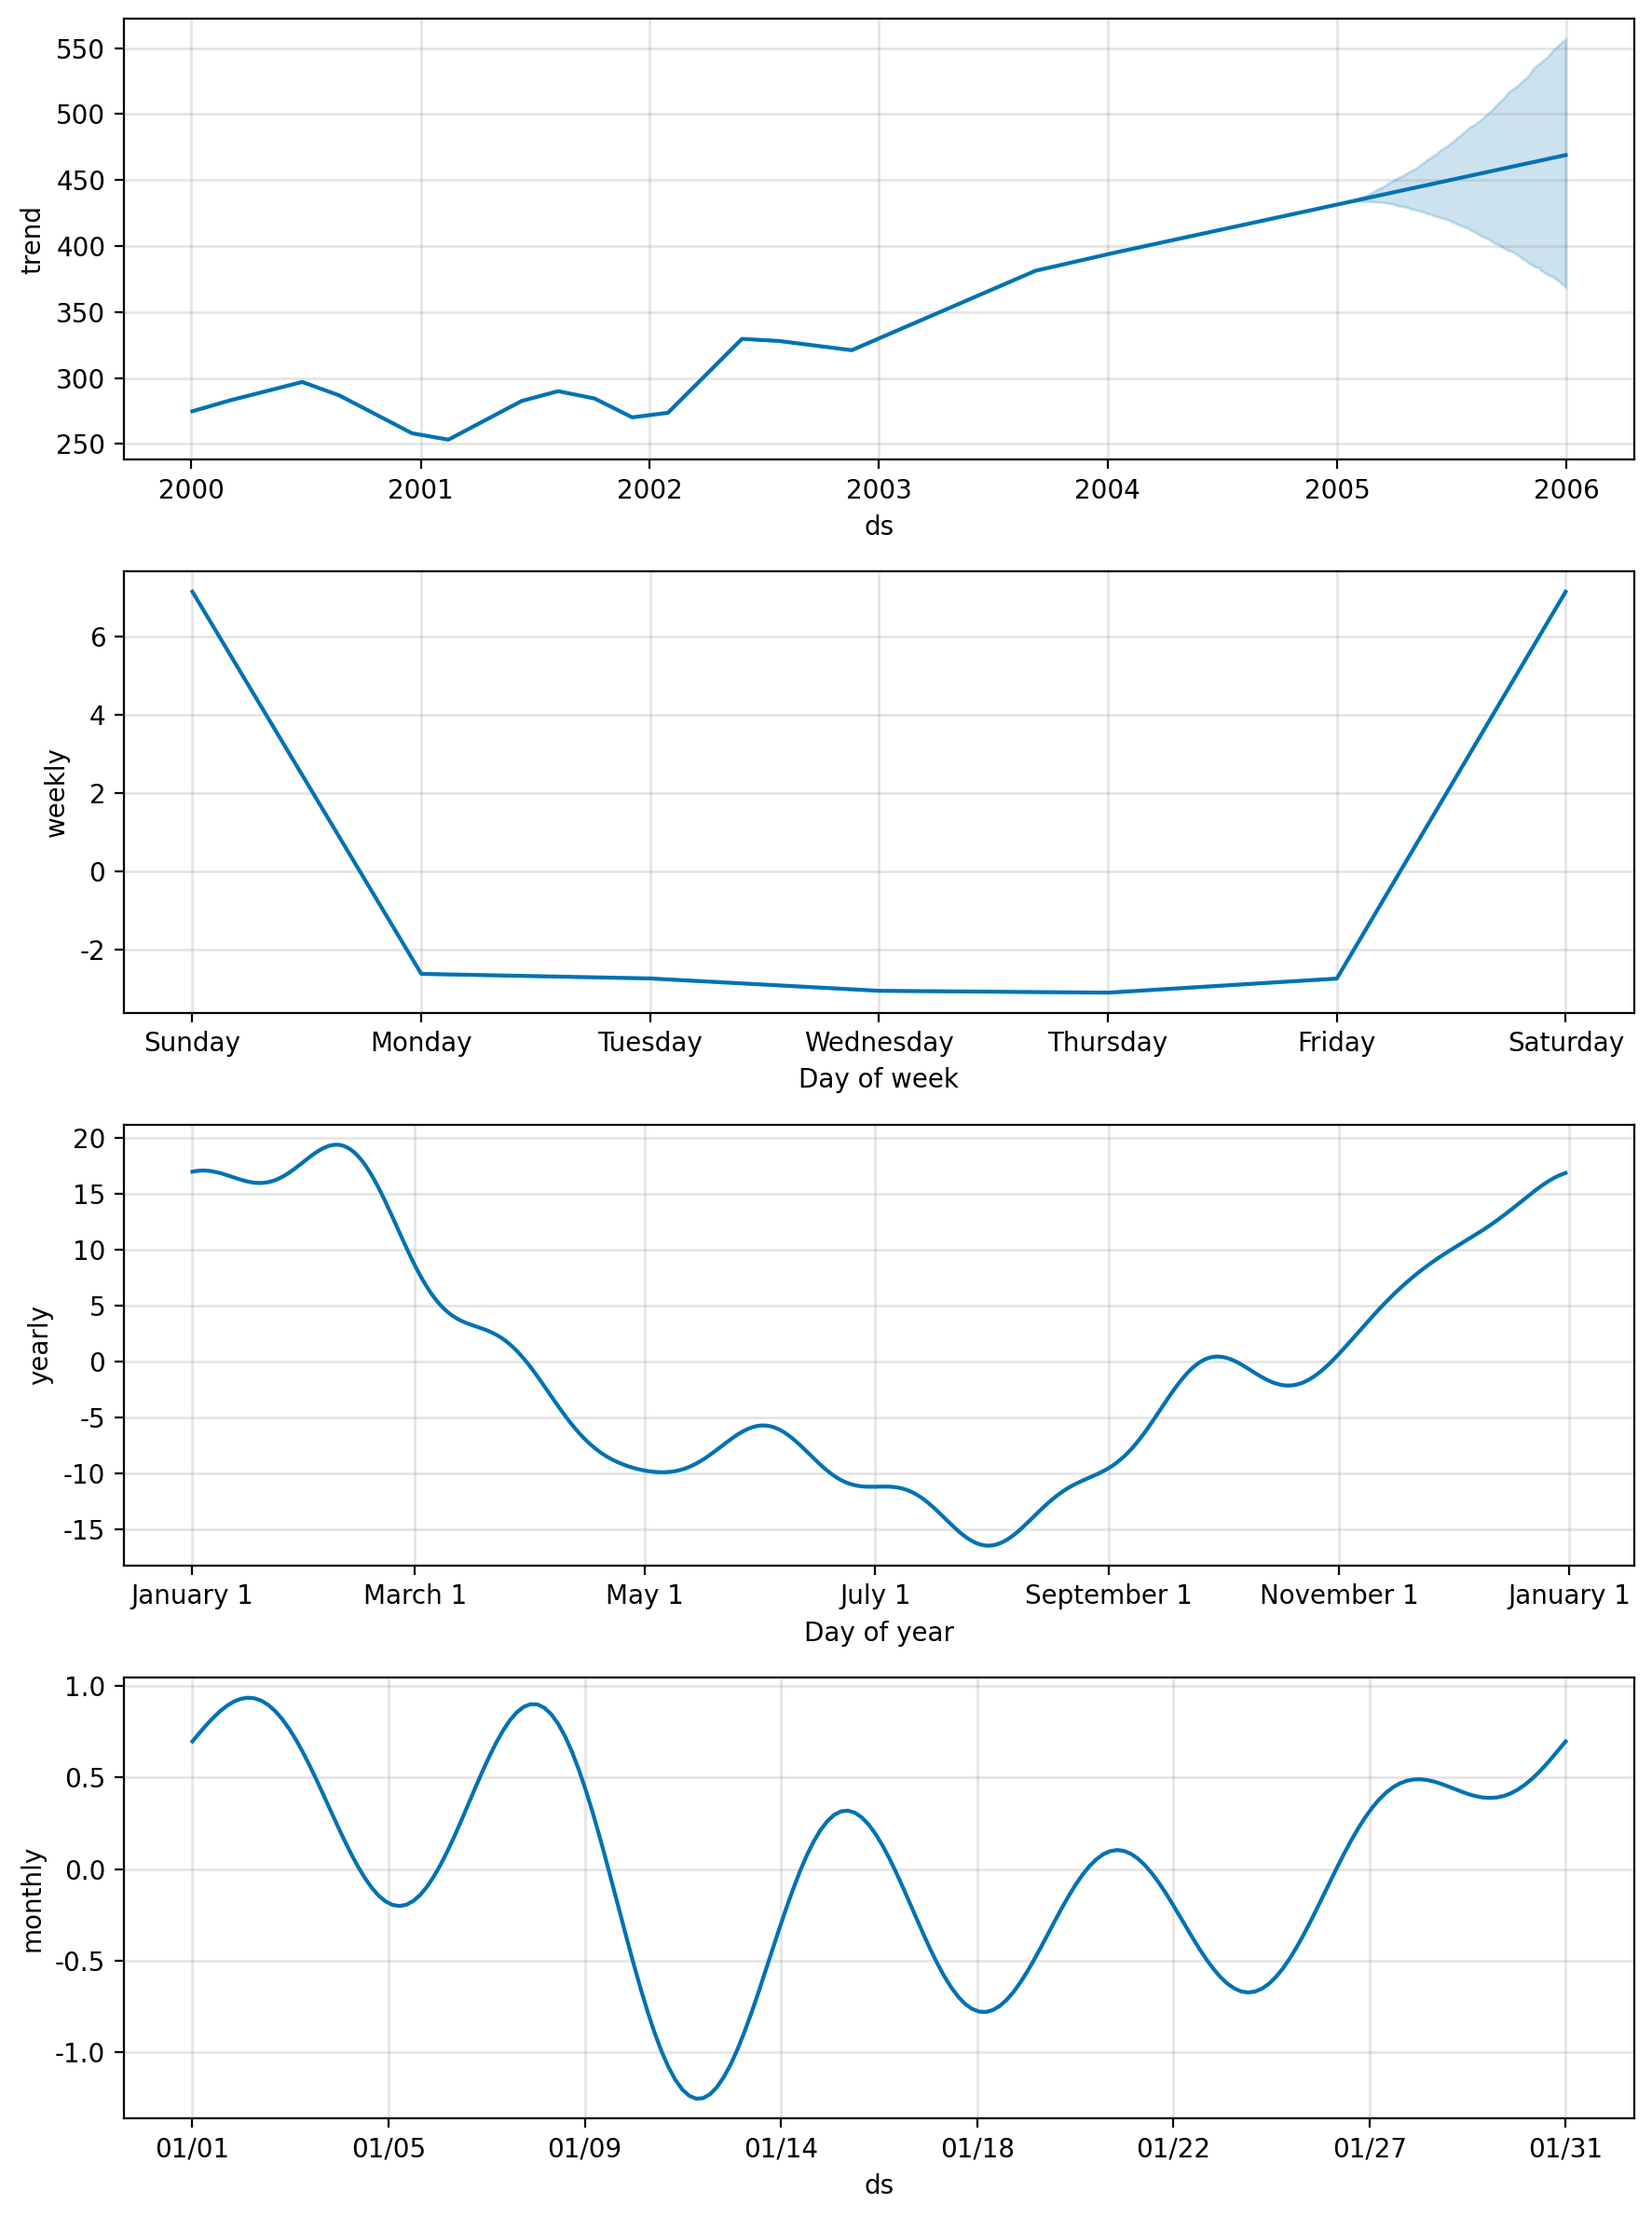

In [ ]:
prophet_decomposition = model_prophet.plot_components(df_pred)

In [ ]:
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']

df_pred = df_pred.loc[:,selected_columns].reset_index(drop = True)
df_test = df_test.merge(df_pred, on = ['ds'], how = 'left')
df_test.ds = pd.to_datetime(df_test.ds)
df_test.set_index('ds', inplace = True)

[Text(0, 0.5, 'Gold Price($)'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Gold Price : Actual vs Predicted')]

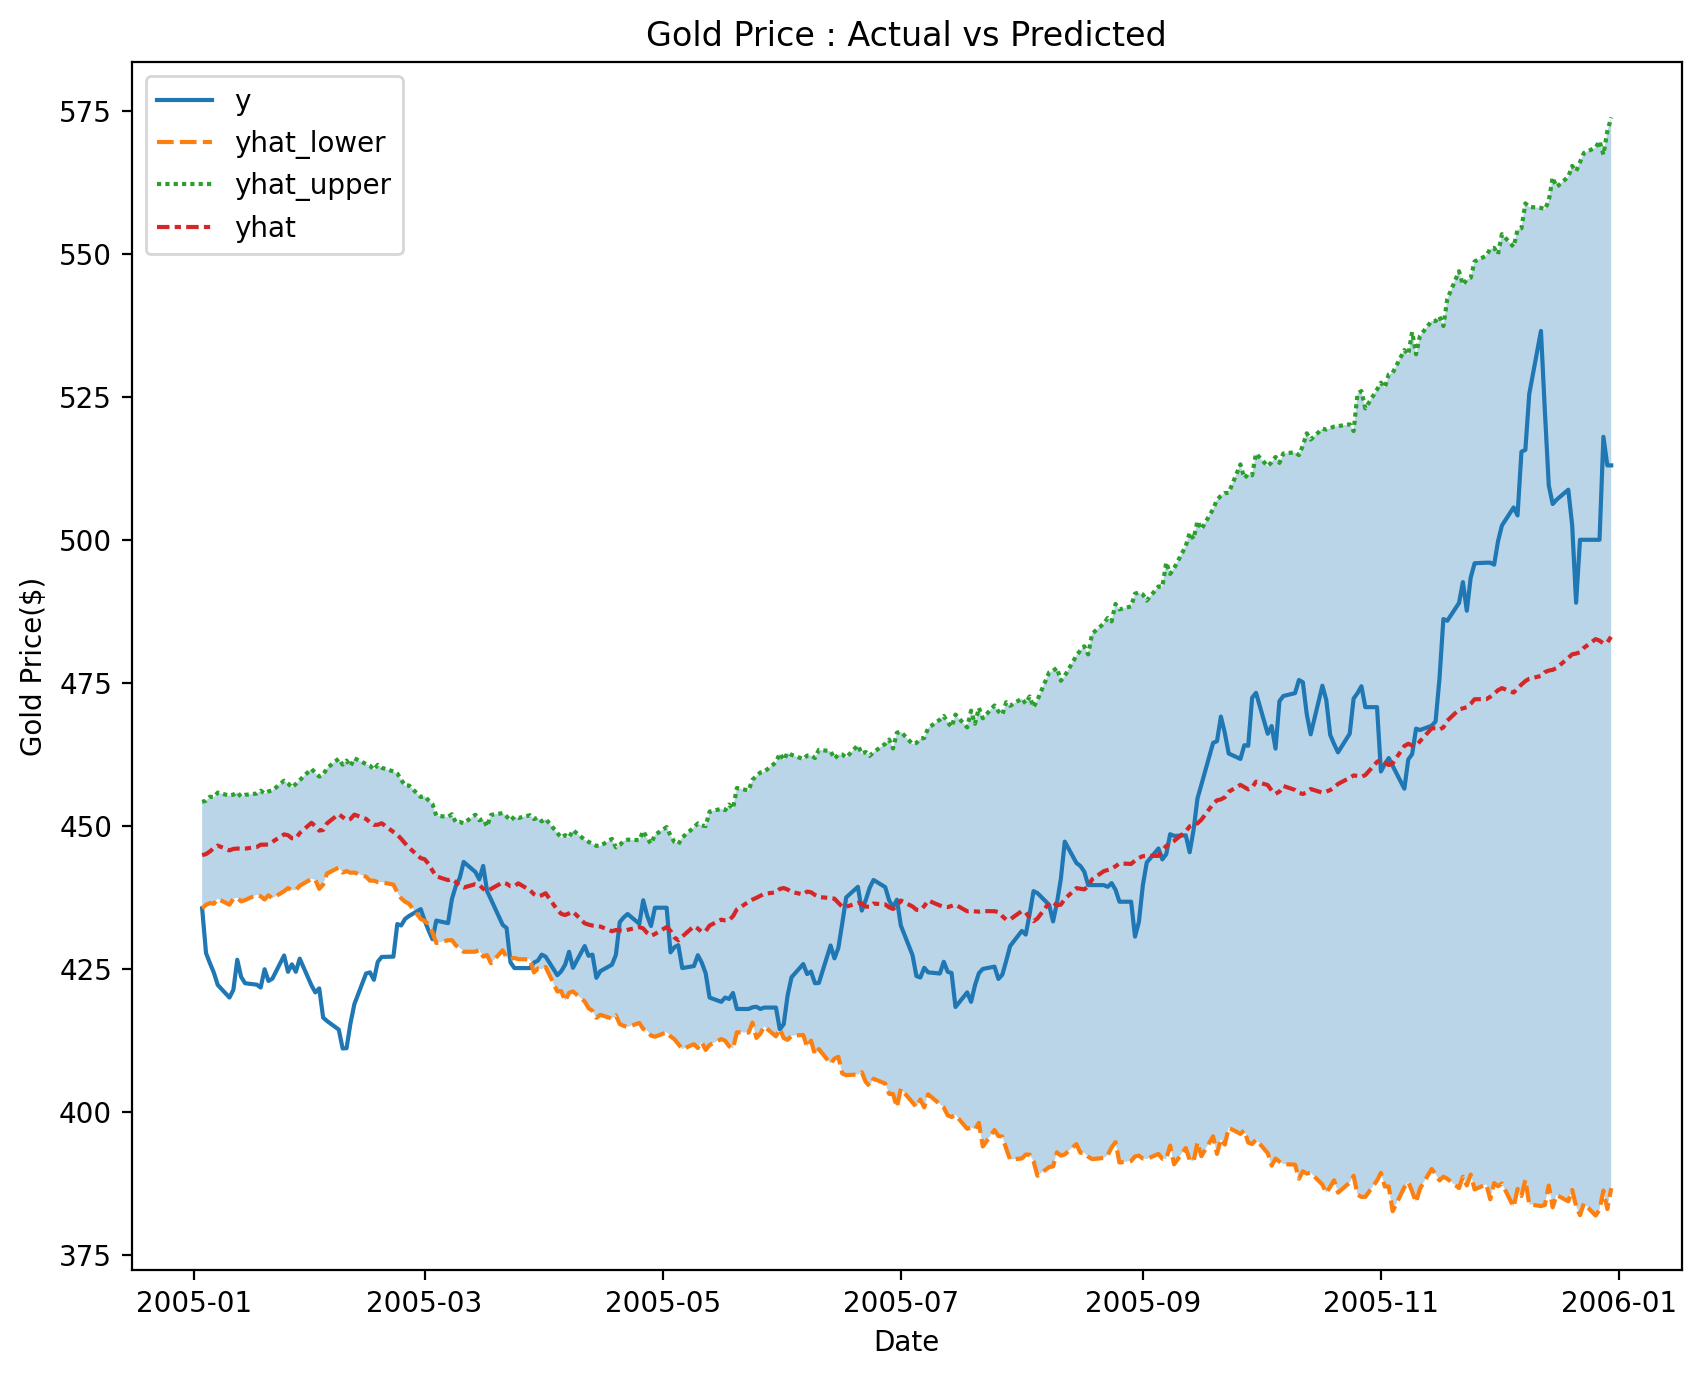

In [ ]:
fig, ax = plt.subplots(1,1)
ax = sns.lineplot(data = df_test[['y', 'yhat_lower', 'yhat_upper', 'yhat']])

ax.fill_between(df_test.index, df_test.yhat_lower, df_test.yhat_upper, alpha = 0.3)
ax.set(title = 'Gold Price : Actual vs Predicted', xlabel = 'Date', ylabel = 'Gold Price($)')

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [ ]:
def adf_test(x):
  indices = ['Test Statistic', 'p-value', '# of Lags Used', '# of Observations Used']
  adf_test = adfuller(x, autolag = 'AIC')
  results = pd.Series(adf_test[0:4], index = indices)
  for key, value in adf_test[4].items():
    results[f'Critical Value ({key})'] = value

  return results

In [ ]:
df = quandl.get(dataset = 'WGC/GOLD_MONAVG_USD', start_date = '2000-01-01', end_date = '2011-12-31')
df.rename(columns = {'Value':'price'}, inplace = True)

df = df.resample('M').last()
df

,price
Date,
2000-01-31,284.31
2000-02-29,299.86
2000-03-31,286.39
2000-04-30,279.69
2000-05-31,275.19
...,...
2011-08-31,1755.81
2011-09-30,1771.85
2011-10-31,1665.21


In [ ]:
adf_test(df.price)

Test Statistic              3.510499
p-value                     1.000000
# of Lags Used             14.000000
# of Observations Used    129.000000
Critical Value (1%)        -3.482088
Critical Value (5%)        -2.884219
Critical Value (10%)       -2.578864
dtype: float64

In [ ]:
def kpss_test(x, h0_type = 'c'):
  indices = ['Test Statistic', 'p-value', '# of Lags']
  kpss_test = kpss(x, regression = h0_type)
  results = pd.Series(kpss_test[0:3], index= indices)
  for key, value in kpss_test[3].items():
    results[f'Critical Value({key}'] = value

  return results

In [ ]:
kpss_test(df.price)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Test Statistic          0.985671
p-value                 0.010000
# of Lags              14.000000
Critical Value(10%      0.347000
Critical Value(5%       0.463000
Critical Value(2.5%     0.574000
Critical Value(1%       0.739000
dtype: float64

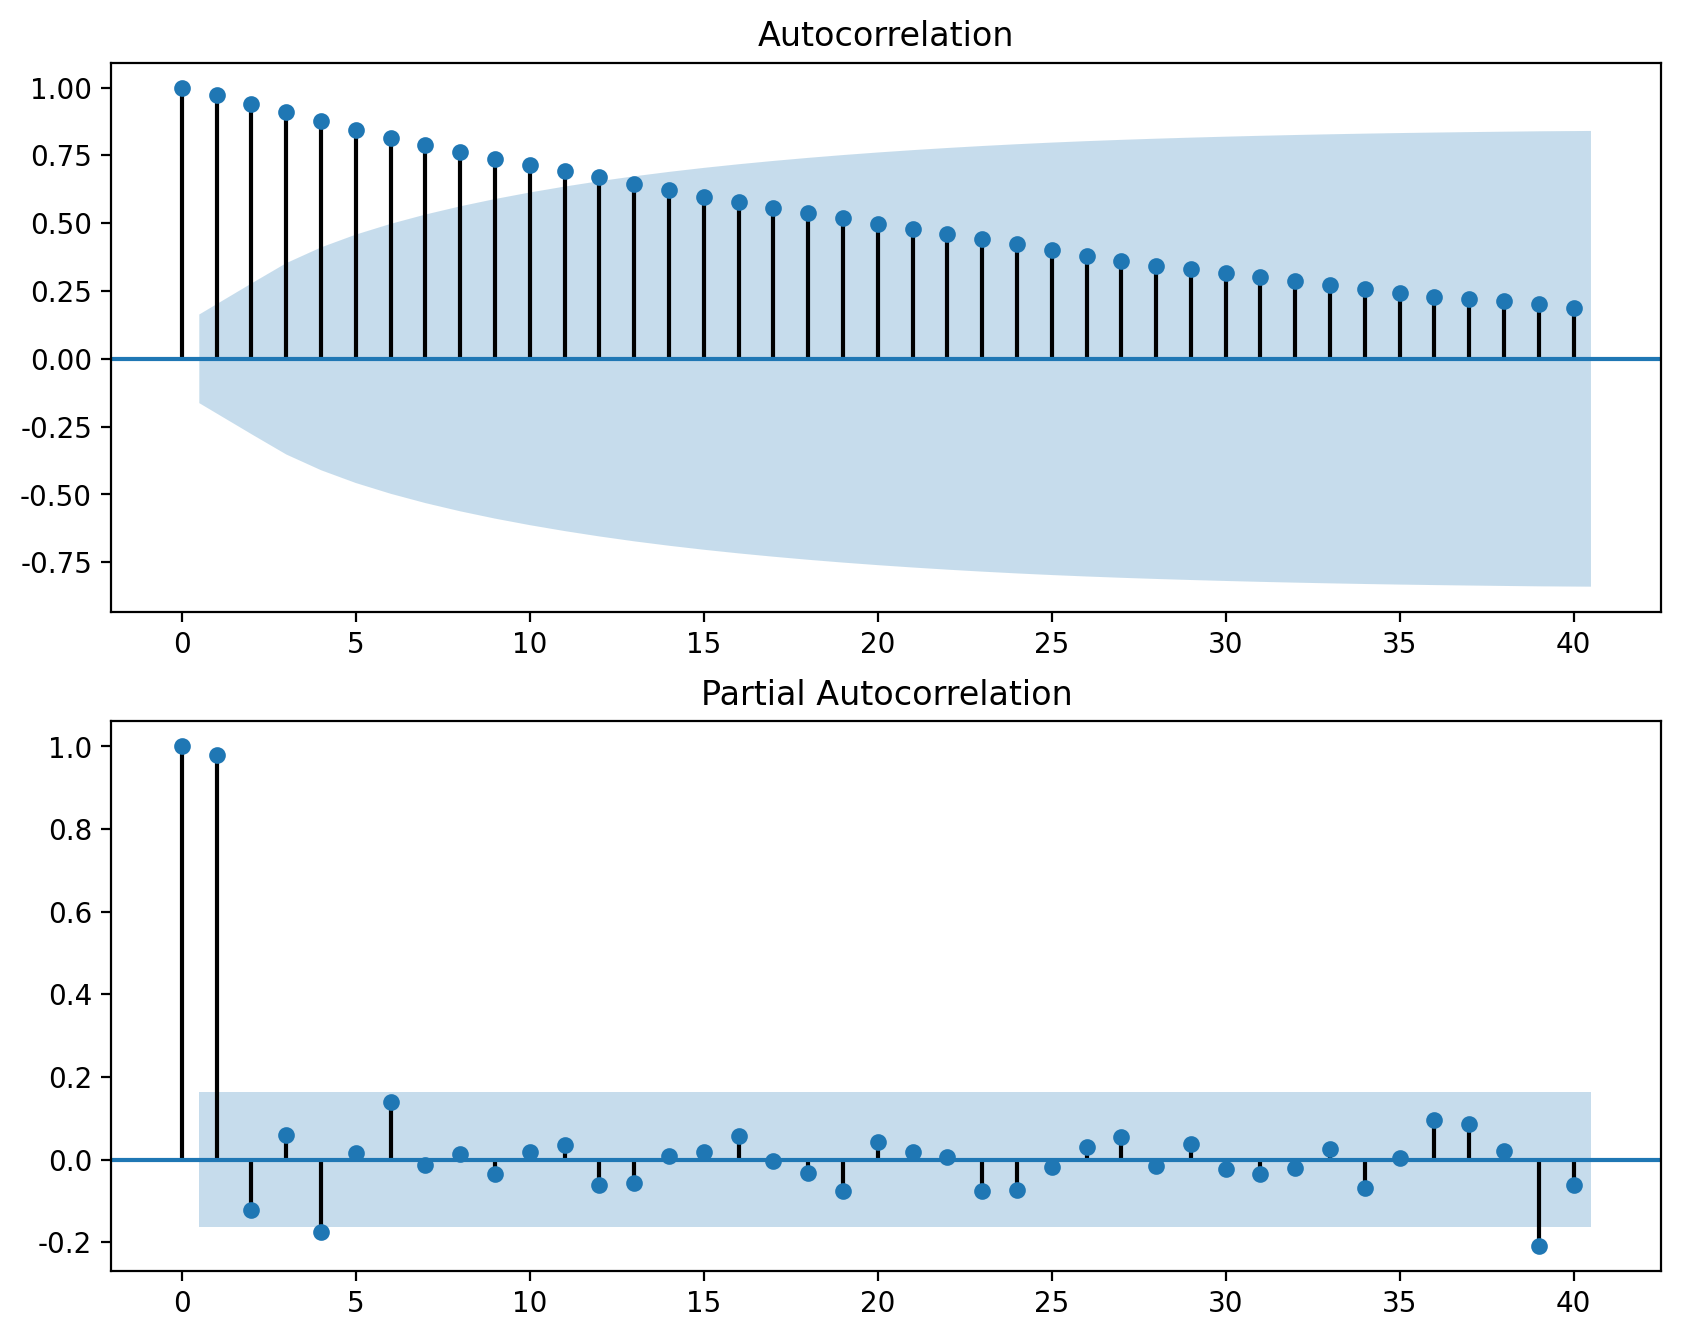

In [ ]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2,1)
plot_acf(df.price, ax = ax[0], lags = N_LAGS, alpha = SIGNIFICANCE_LEVEL);
plot_pacf(df.price, ax = ax[1], lags = N_LAGS, alpha = SIGNIFICANCE_LEVEL);

In [ ]:
import cpi
from datetime import date

INFO:cpi:Parsing data files from the BLS


In [ ]:
def test_autocorrelation(x, n_lags=40, alpha=0.05, h0_type='c'):
    '''
    Function for testing the stationarity of a series by using:
    * the ADF test
    * the KPSS test
    * ACF/PACF plots
    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    n_lags : int
        The number of lags for the ACF/PACF plots
    alpha : float
        Significance level for the ACF/PACF plots
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure containing the ACF/PACF plot
    '''

    adf_results = adf_test(x)
    kpss_results = kpss_test(x, h0_type=h0_type)

    print('ADF test statistic(Null = Series not Stationary): {:.2f} (p-val: {:.2f})'.format(adf_results['Test Statistic'],
                                                             adf_results['p-value']))
    print('KPSS test statistic(Null = Series Stationary): {:.2f} (p-val: {:.2f})'.format(kpss_results['Test Statistic'],
                                                              kpss_results['p-value']))

    fig, ax = plt.subplots(2, figsize=(16, 8))
    plot_acf(x, ax=ax[0], lags=n_lags, alpha=alpha)
    plot_pacf(x, ax=ax[1], lags=n_lags, alpha=alpha)

    return fig


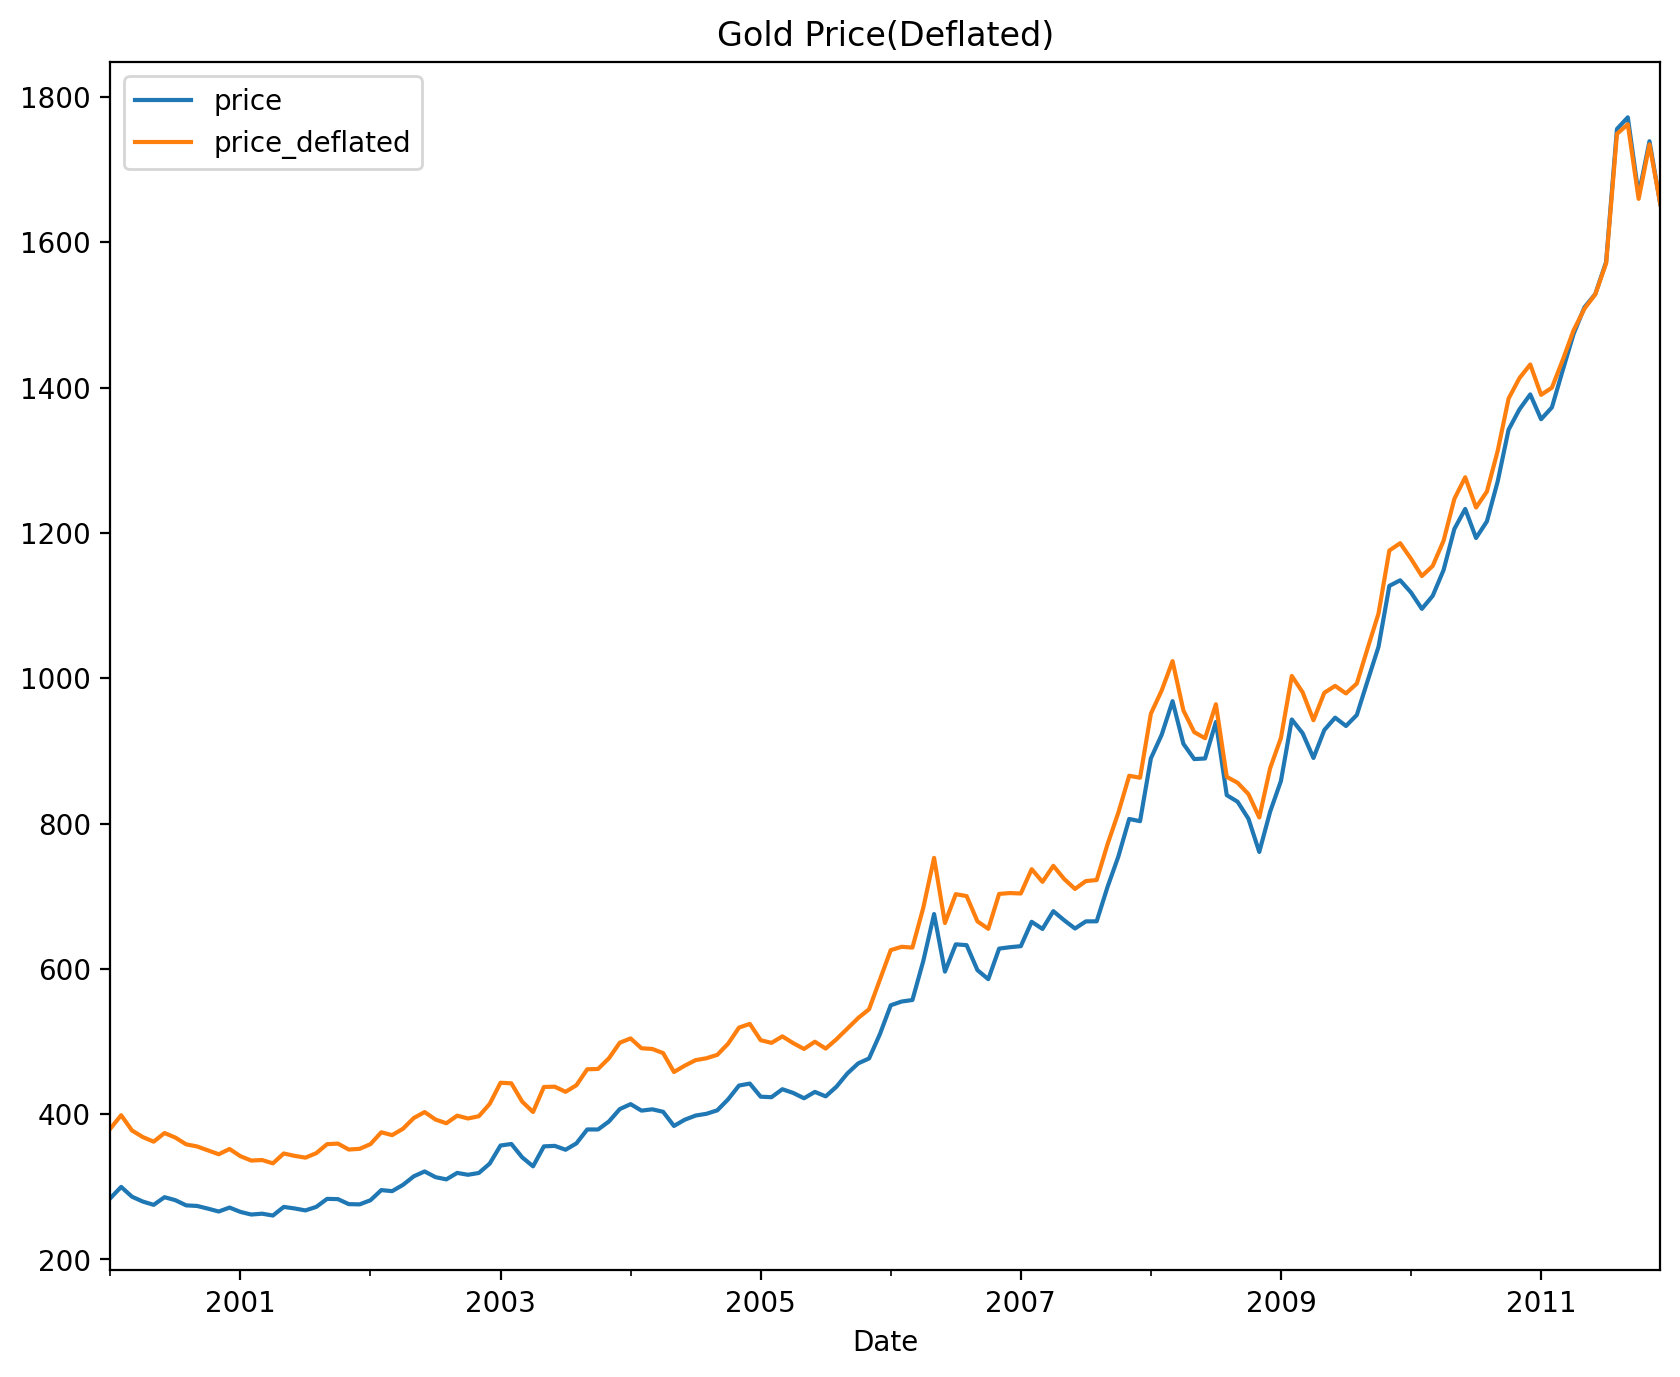

In [ ]:
DEFL_DATE = date(2011,12,31)
df['dt_index'] = df.index.map(lambda x: x.to_pydatetime().date())
df['price_deflated'] = df.apply(lambda x: cpi.inflate(x.price, x.dt_index, DEFL_DATE), axis = 1)

df[['price', 'price_deflated']].plot(title = 'Gold Price(Deflated)');

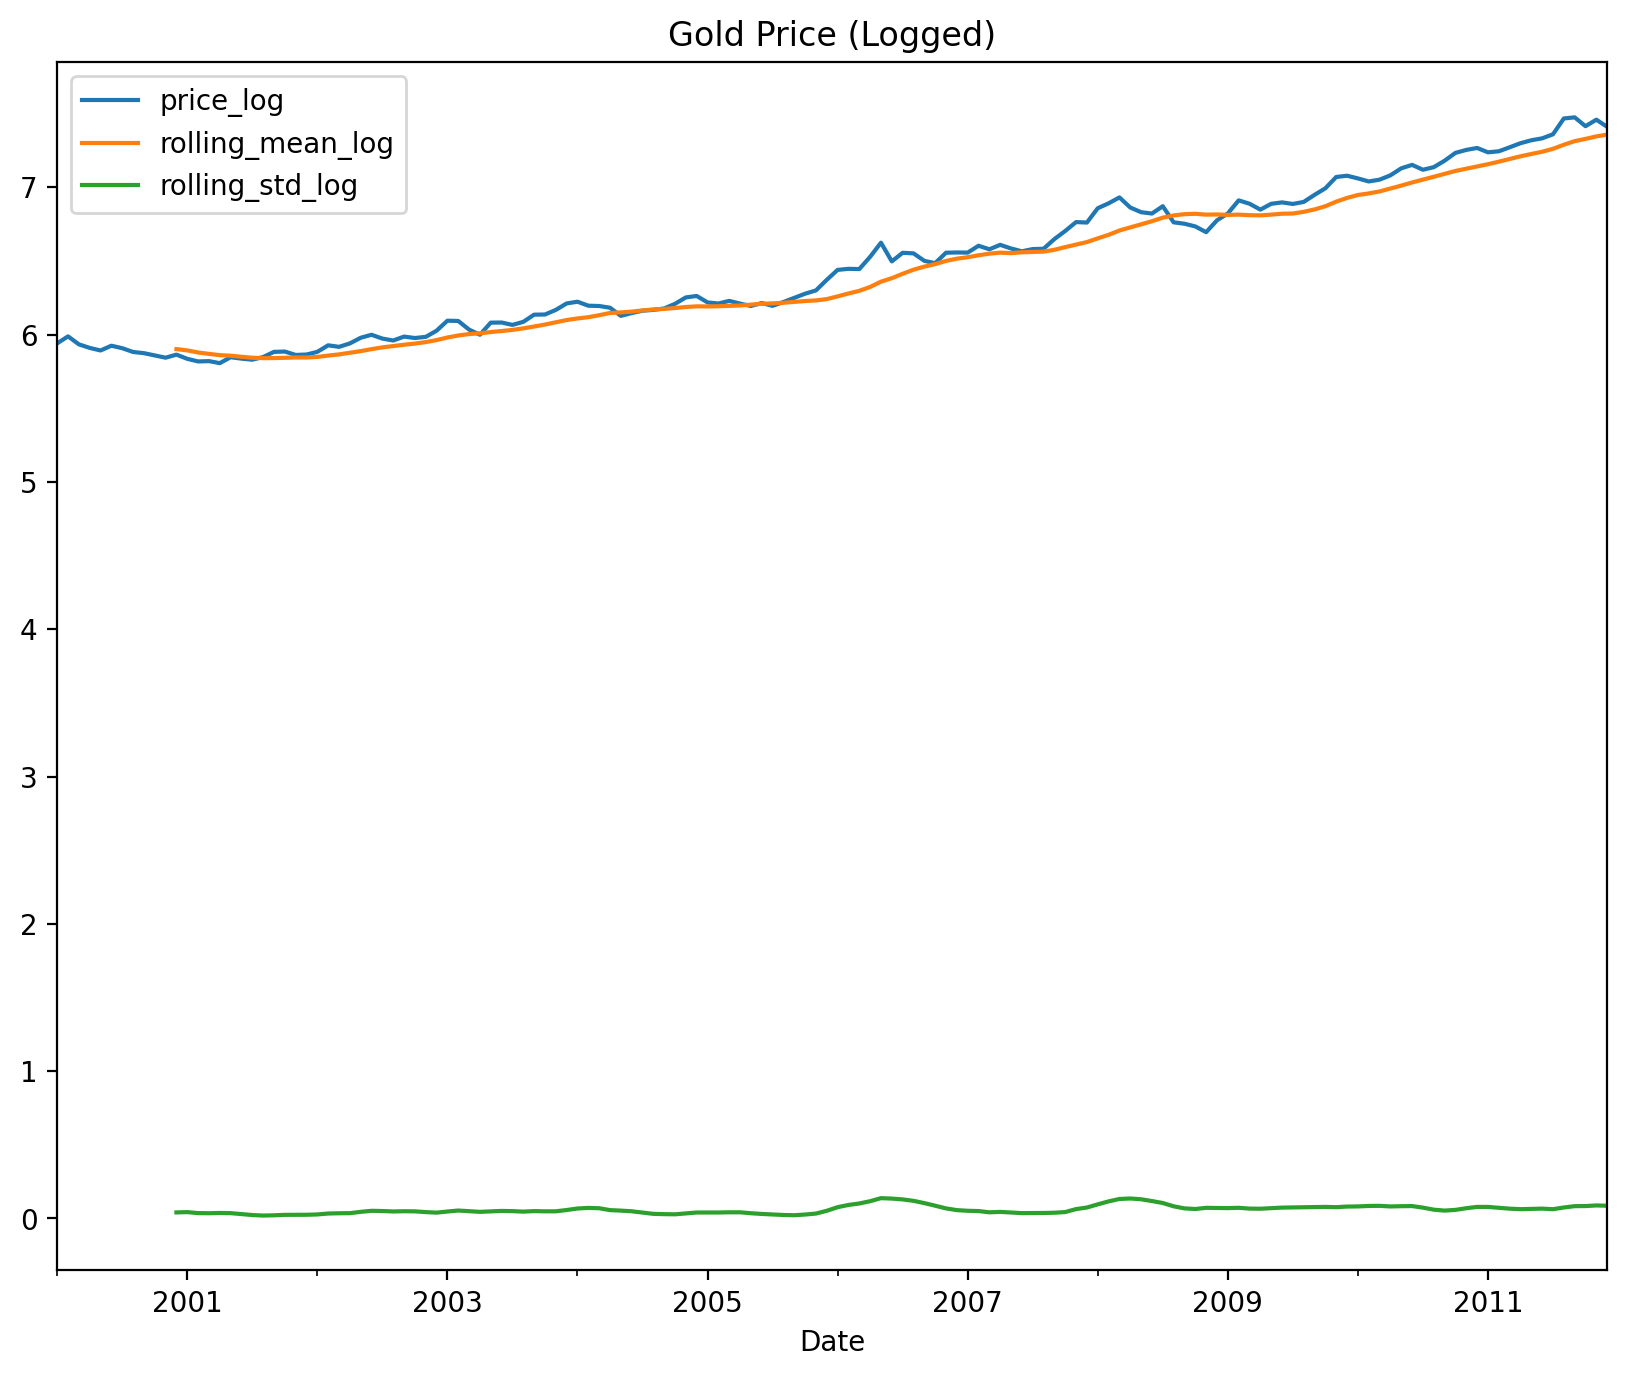

In [ ]:
WINDOW = 12
selected_columns = ['price_log', 'rolling_mean_log', 'rolling_std_log']

df['price_log'] = np.log(df.price_deflated)
df['rolling_mean_log'] = df.price_log.rolling(window = WINDOW).mean()
df['rolling_std_log'] = df.price_log.rolling(window = WINDOW).std()

df[selected_columns].plot(title = 'Gold Price (Logged)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


ADF test statistic: 0.89 (p-val: 0.99)
KPSS test statistic: 1.04 (p-val: 0.01)


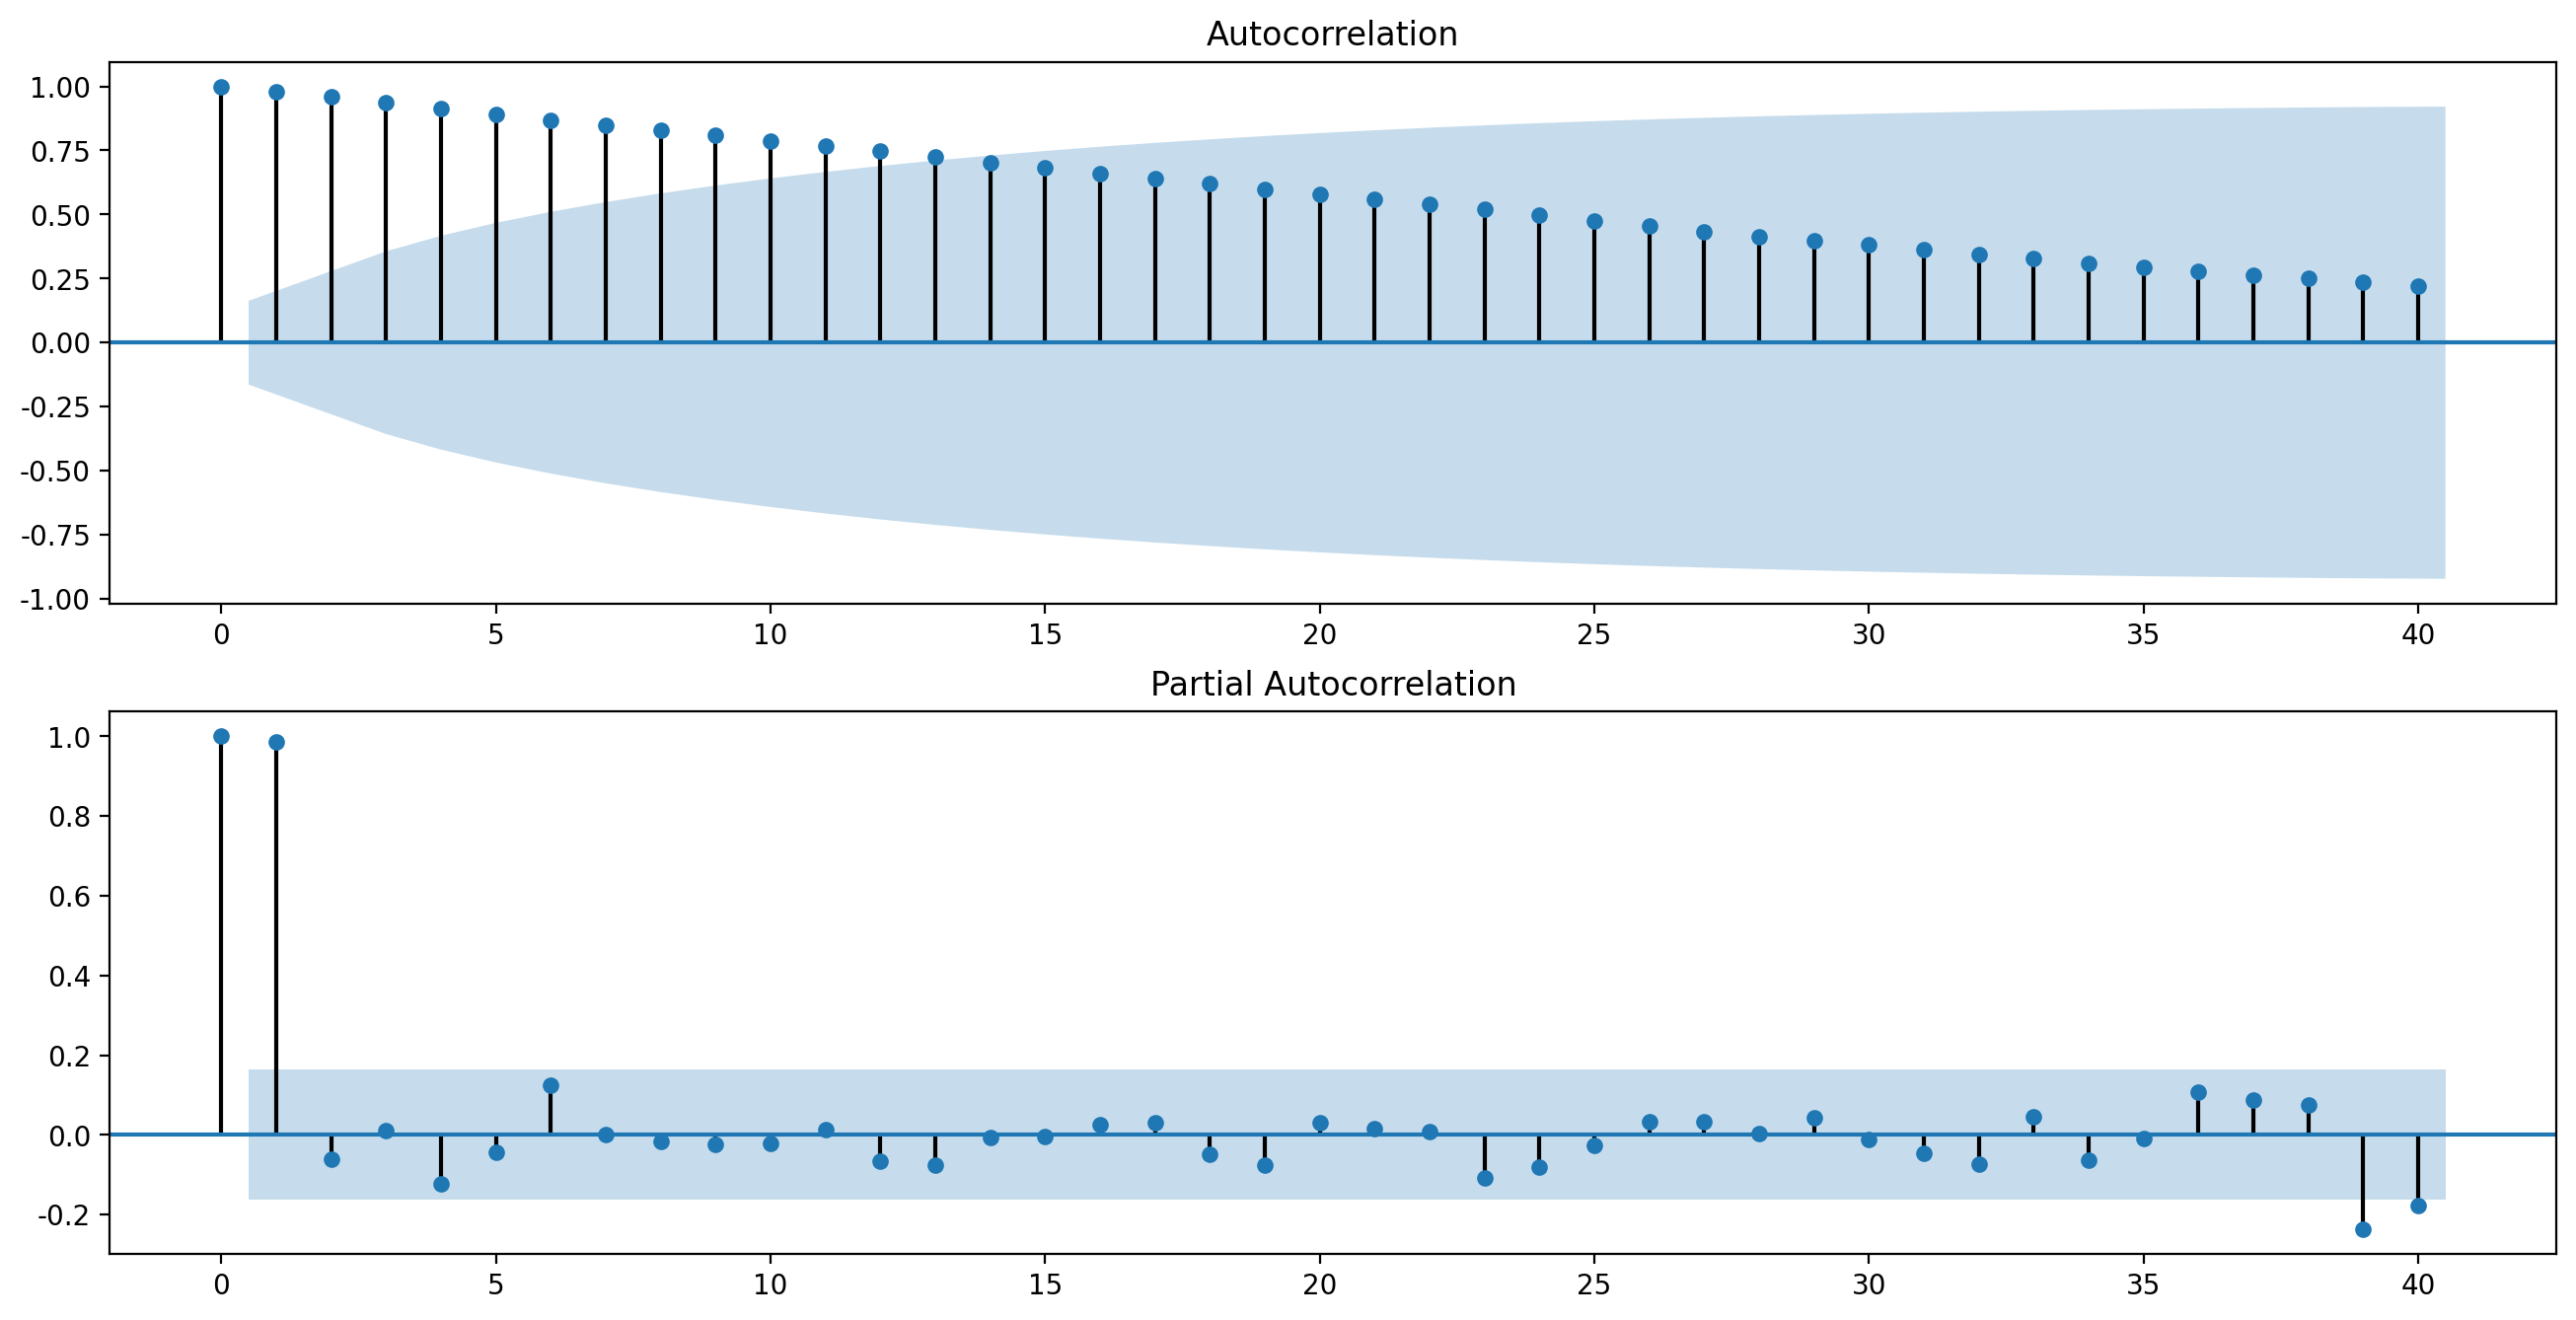

In [ ]:
test_autocorrelation(df.price_log);

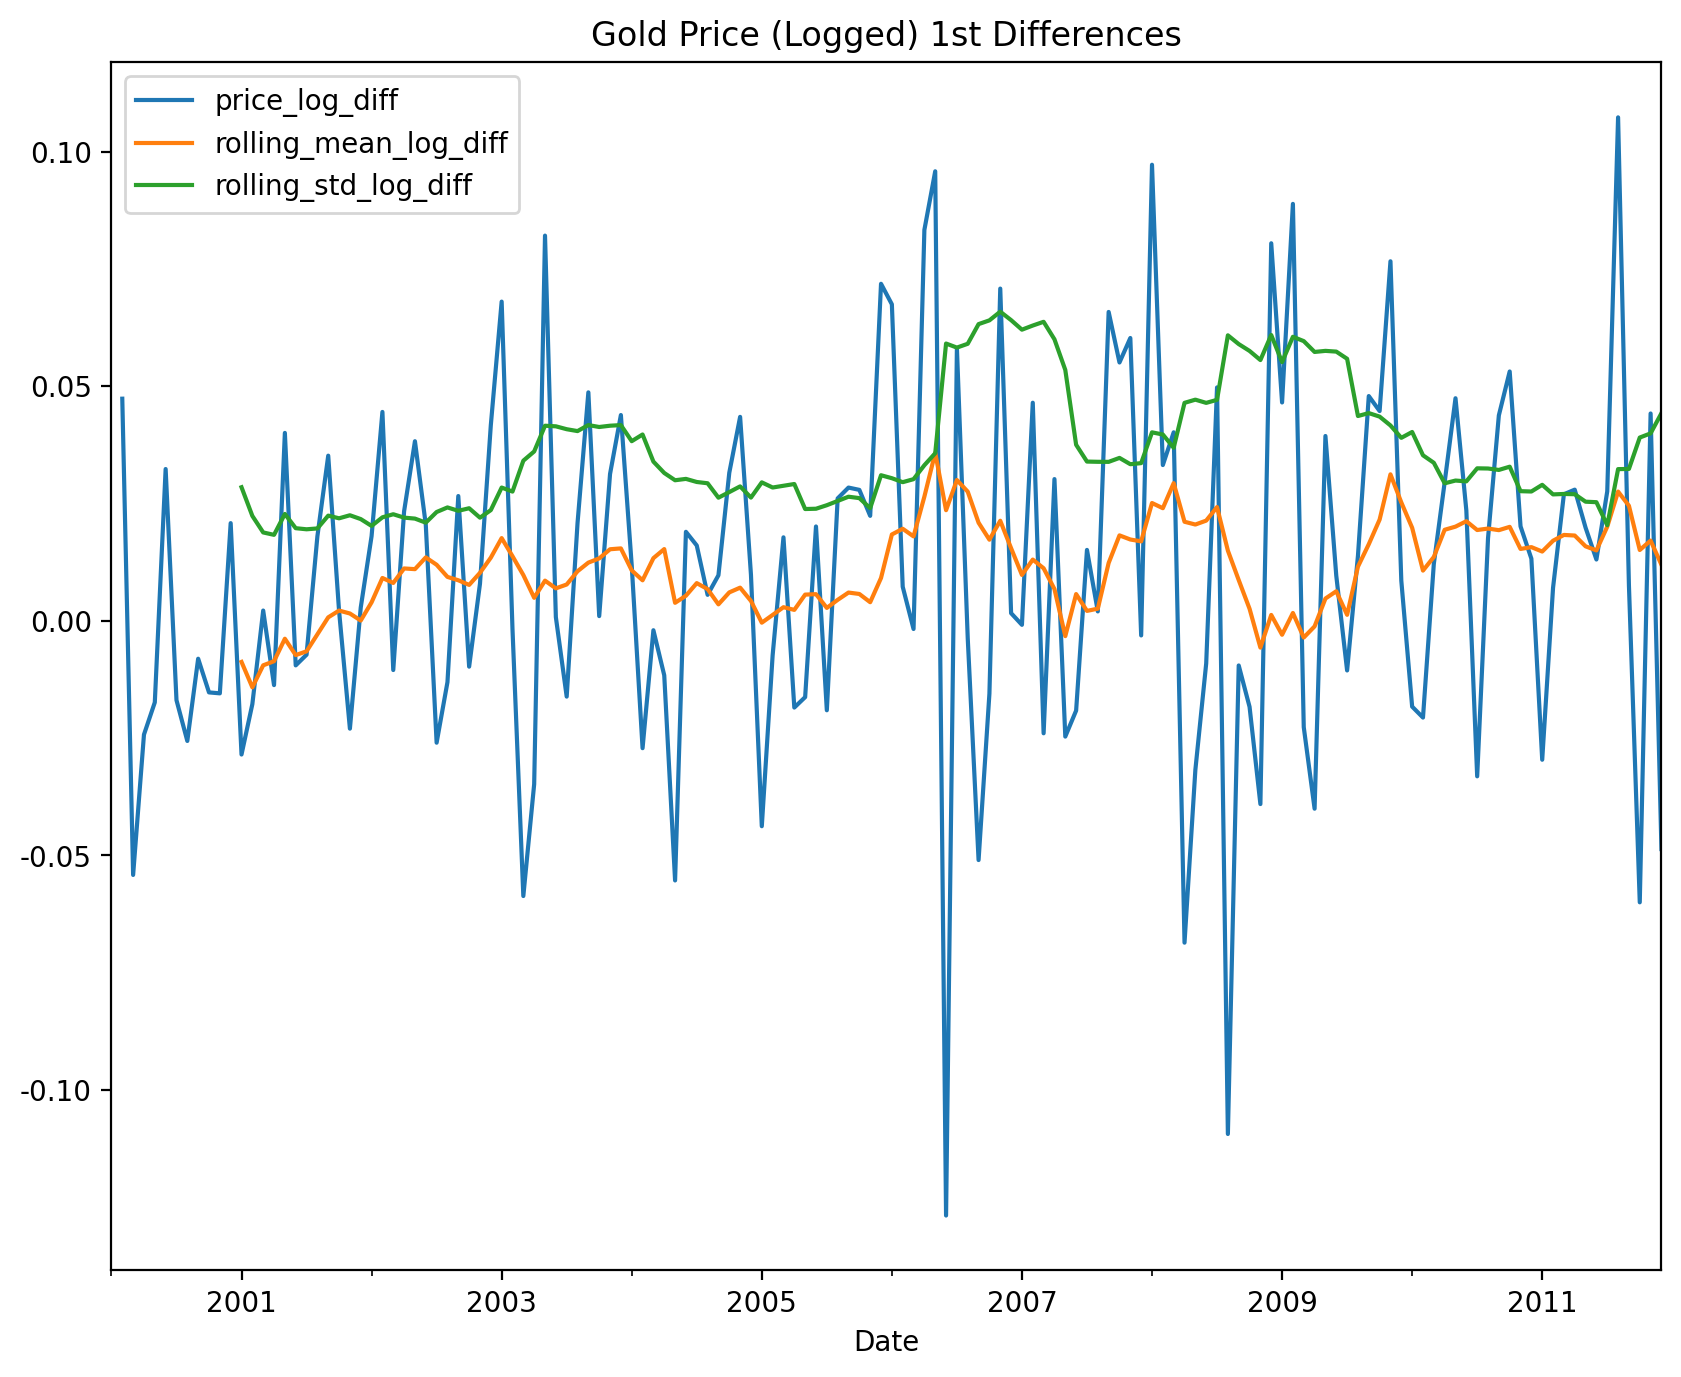

In [ ]:
selected_columns = ['price_log_diff', 'rolling_mean_log_diff', 'rolling_std_log_diff']

df['price_log_diff'] = df.price_log.diff(1)
df['rolling_mean_log_diff'] = df.price_log_diff.rolling(window = WINDOW).mean()
df['rolling_std_log_diff'] = df.price_log_diff.rolling(window = WINDOW).std()

df[selected_columns].plot(title = 'Gold Price (Logged) 1st Differences')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


ADF test statistic: -9.13 (p-val: 0.00)
KPSS test statistic: 0.37 (p-val: 0.09)


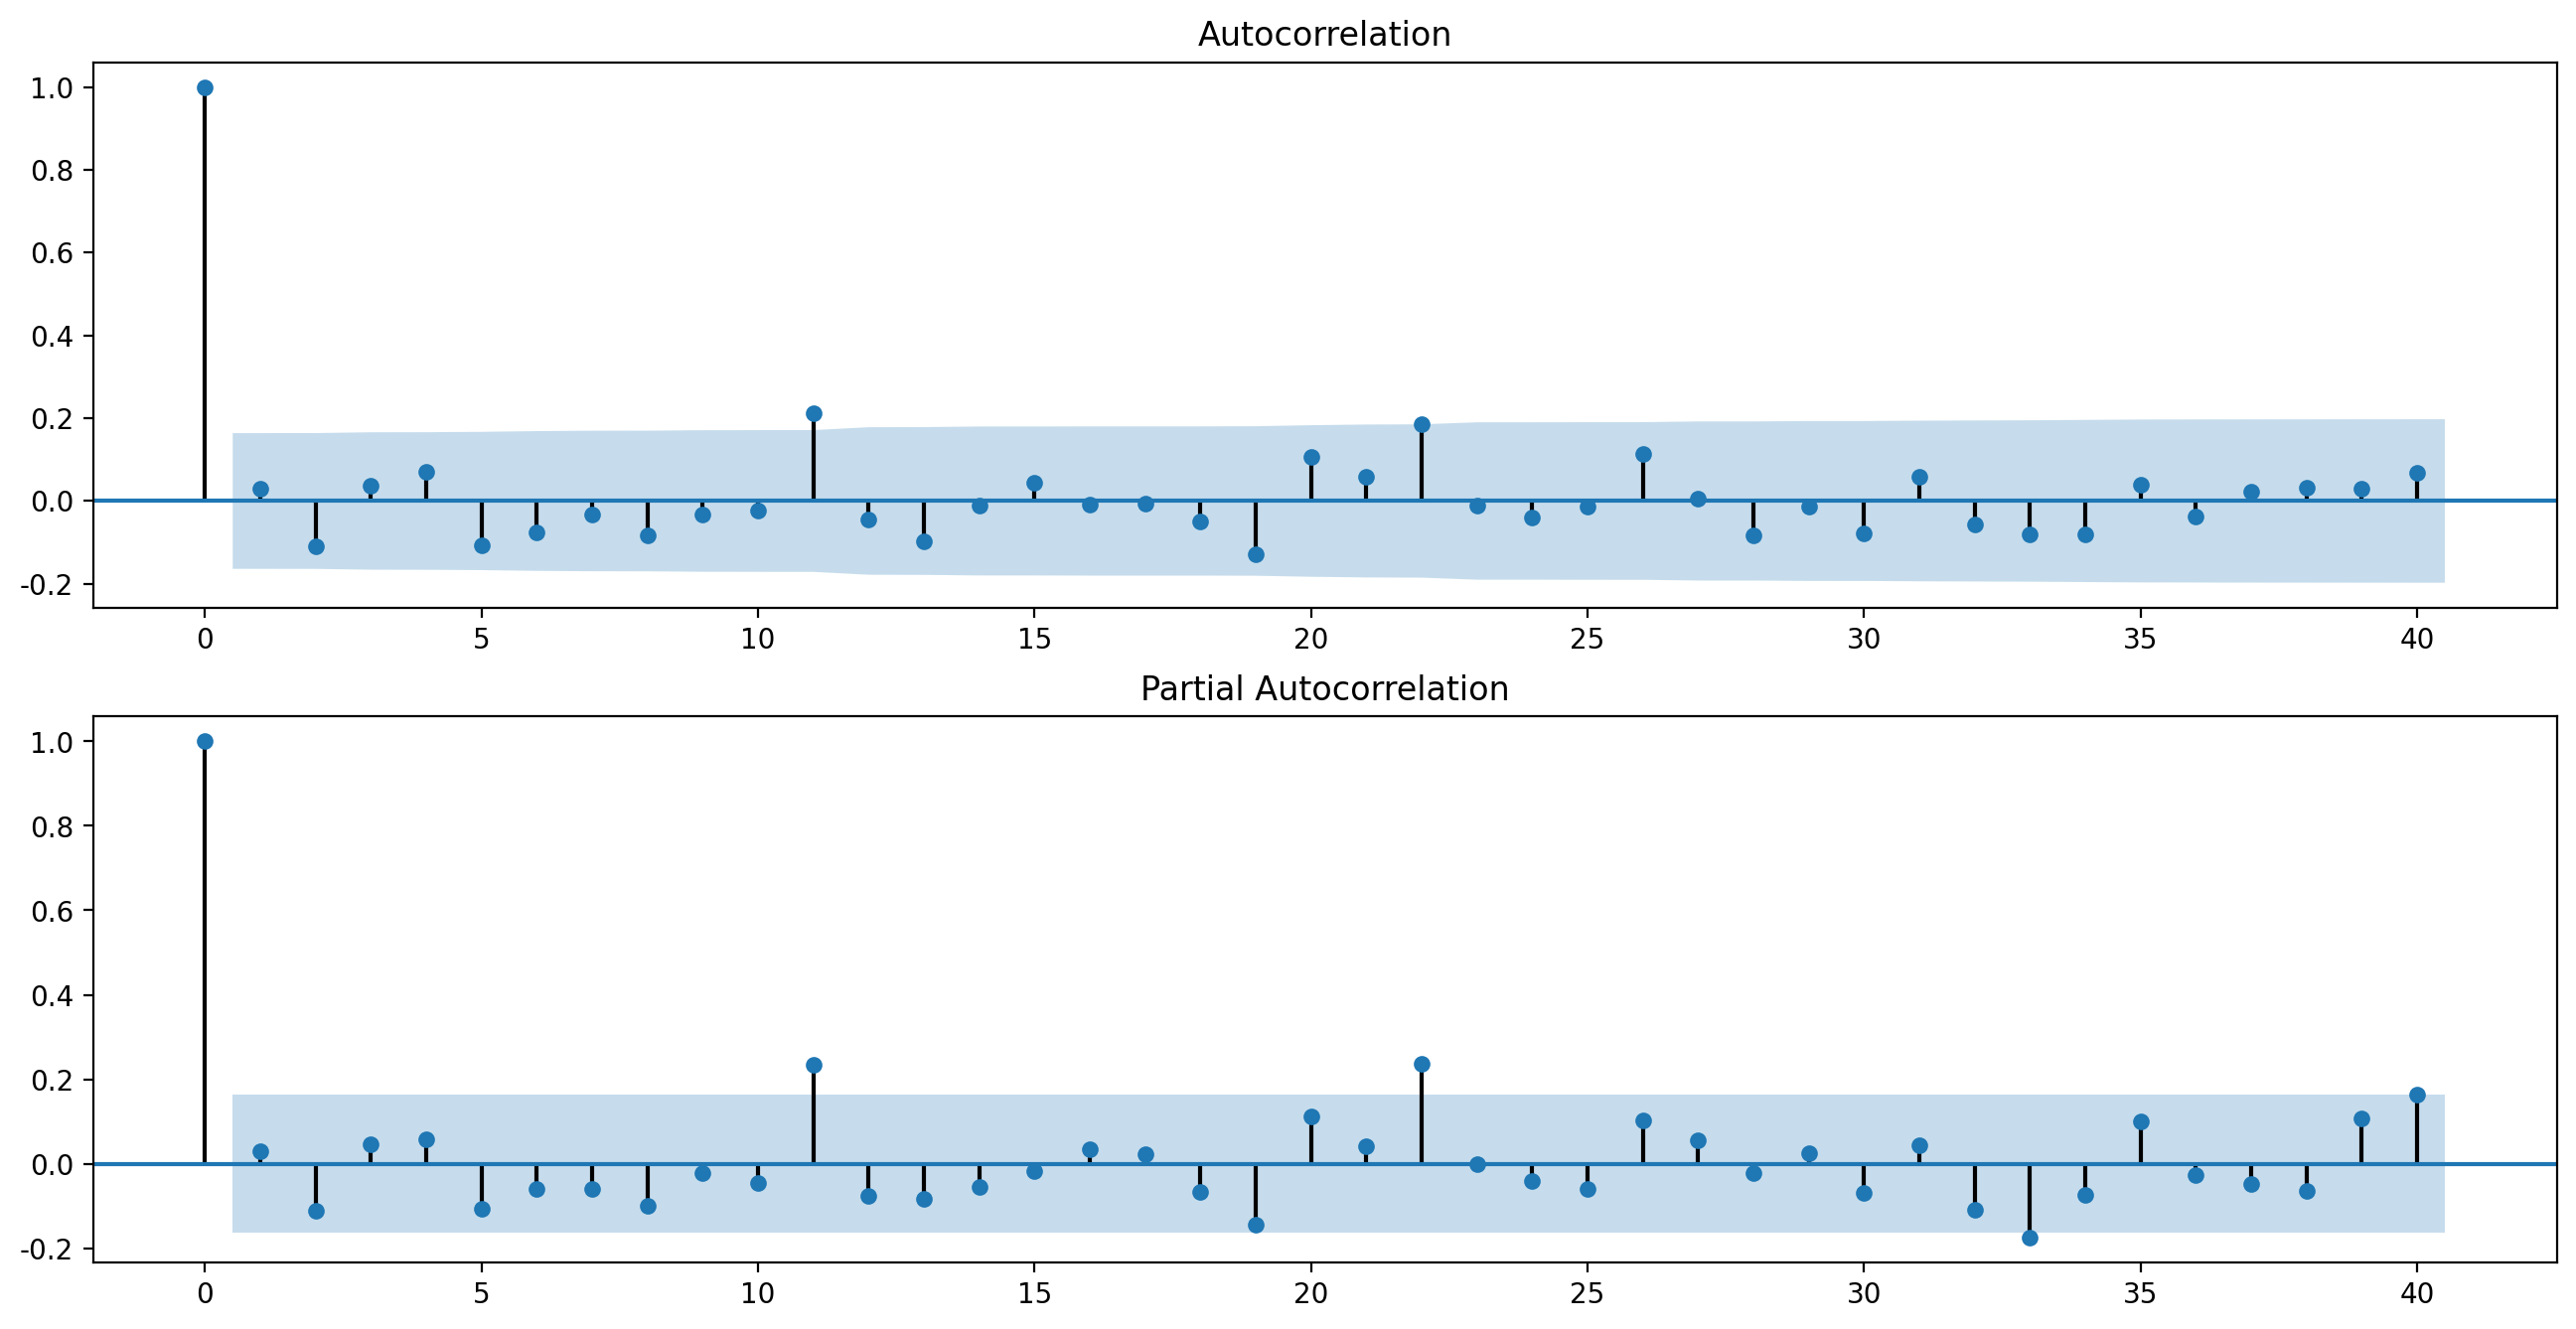

In [ ]:
test_autocorrelation(df.price_log_diff.dropna());

In [ ]:
plt.set_cmap('cubehelix')
sns.set_palette('cubehelix')

COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]

<Figure size 2000x1600 with 0 Axes>

In [ ]:
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, SimpleExpSmoothing, Holt)

In [ ]:
df = yf.download('GOOG', start = '2010-01-01', end = '2018-12-31', adjusted = True, progress = False)
#print(df.head())
goog = df.resample('M').last().rename(columns = {'Adj Close': 'adj_close'}).adj_close
print(goog.head())

Date
2010-01-31    263.980530
2010-02-28    262.416412
2010-03-31    282.501129
2010-04-30    261.868439
2010-05-31    241.908264
Freq: M, Name: adj_close, dtype: float64


In [ ]:
train_indices = goog.index.year < 2018
goog_train = goog[train_indices]
goog_test = goog[~train_indices]

test_length = len(goog_test)

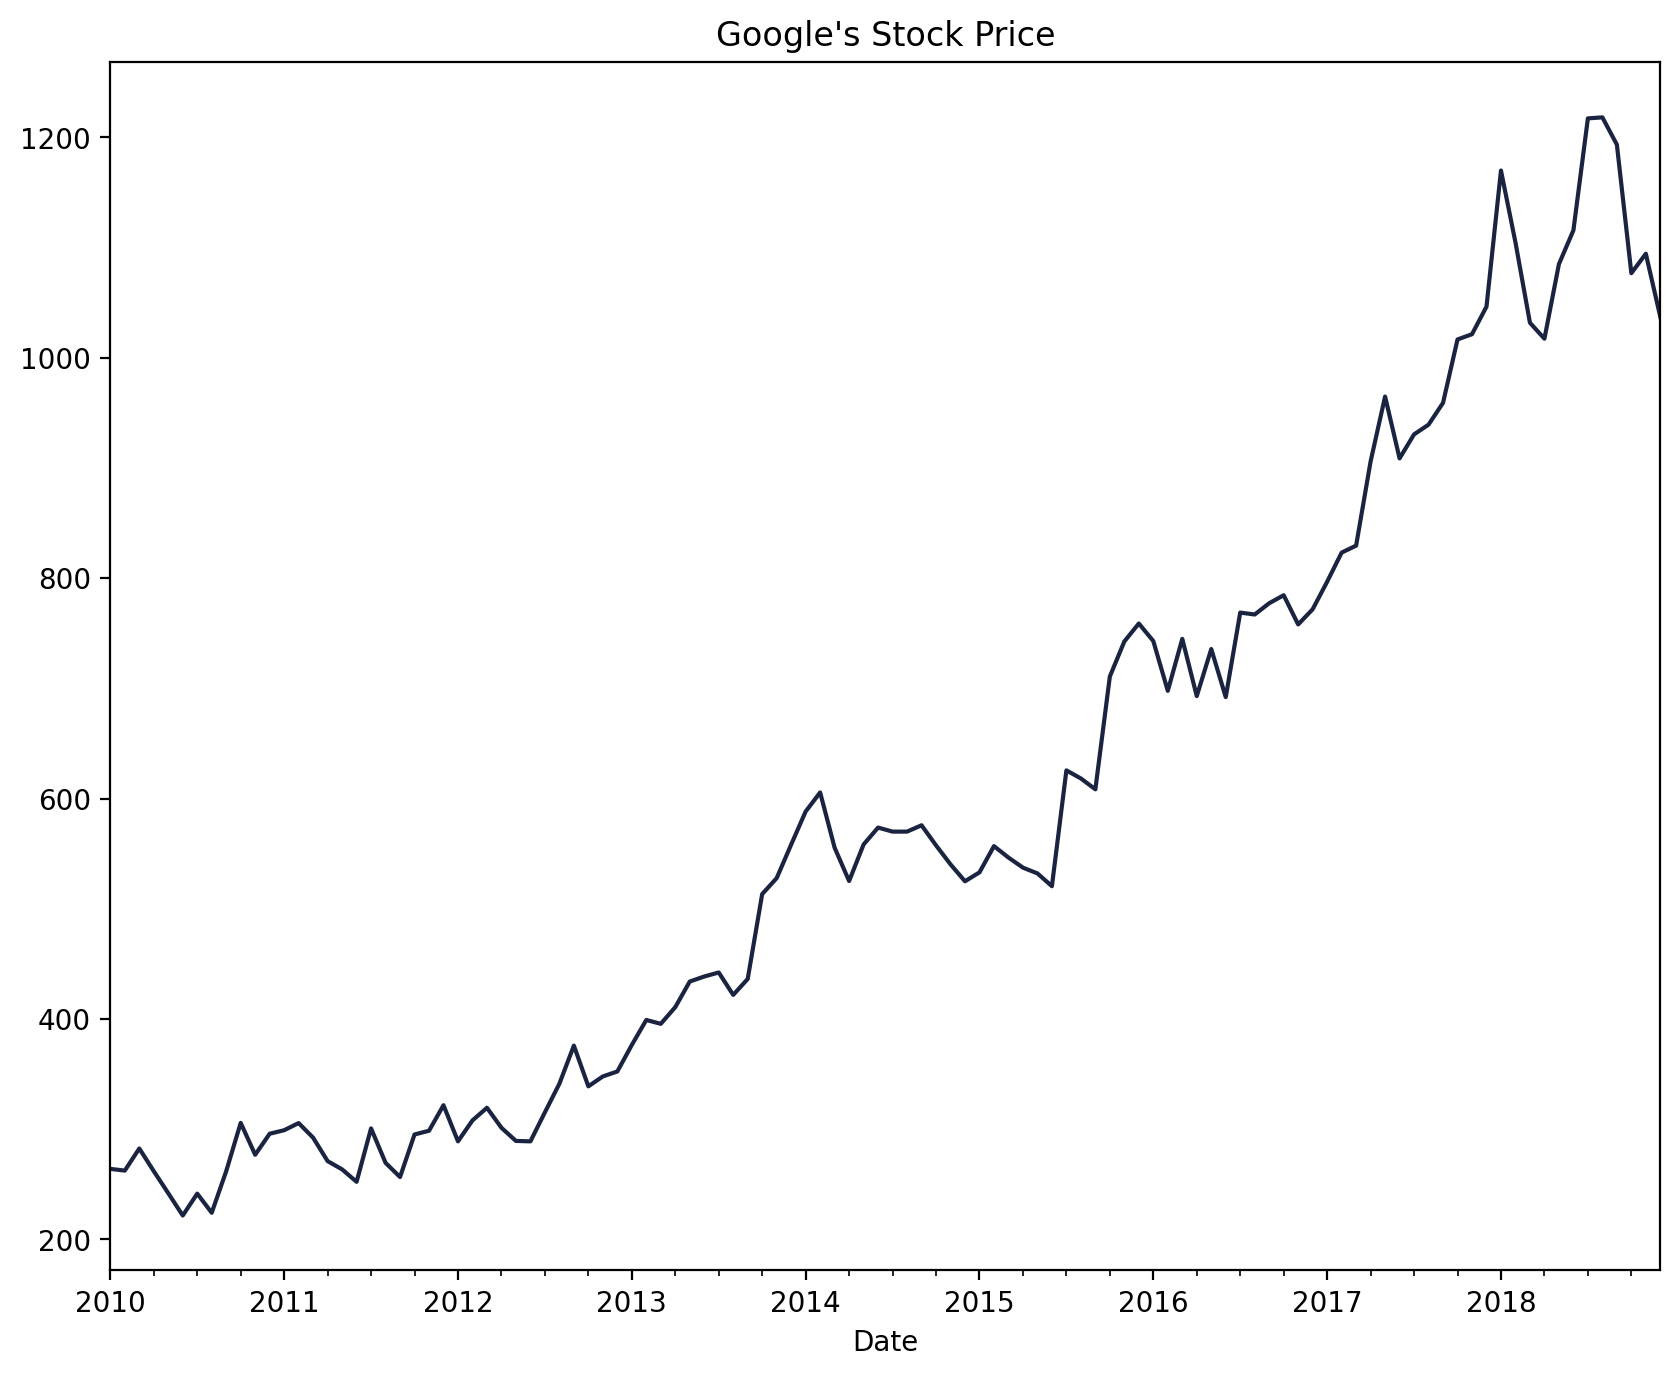

In [ ]:
goog.plot(title = 'Google\'s Stock Price' )

In [ ]:
ses_1 = SimpleExpSmoothing(goog_train).fit(smoothing_level = 0.2)
ses_forecast_1 = ses_1.forecast(test_length)

ses_2 = SimpleExpSmoothing(goog_train).fit(smoothing_level = 0.5)
ses_forecast_2 = ses_2.forecast(test_length)

ses_3 = SimpleExpSmoothing(goog_train).fit()
alpha = ses_3.model.params['smoothing_level']
ses_forecast_3 = ses_3.forecast(test_length)

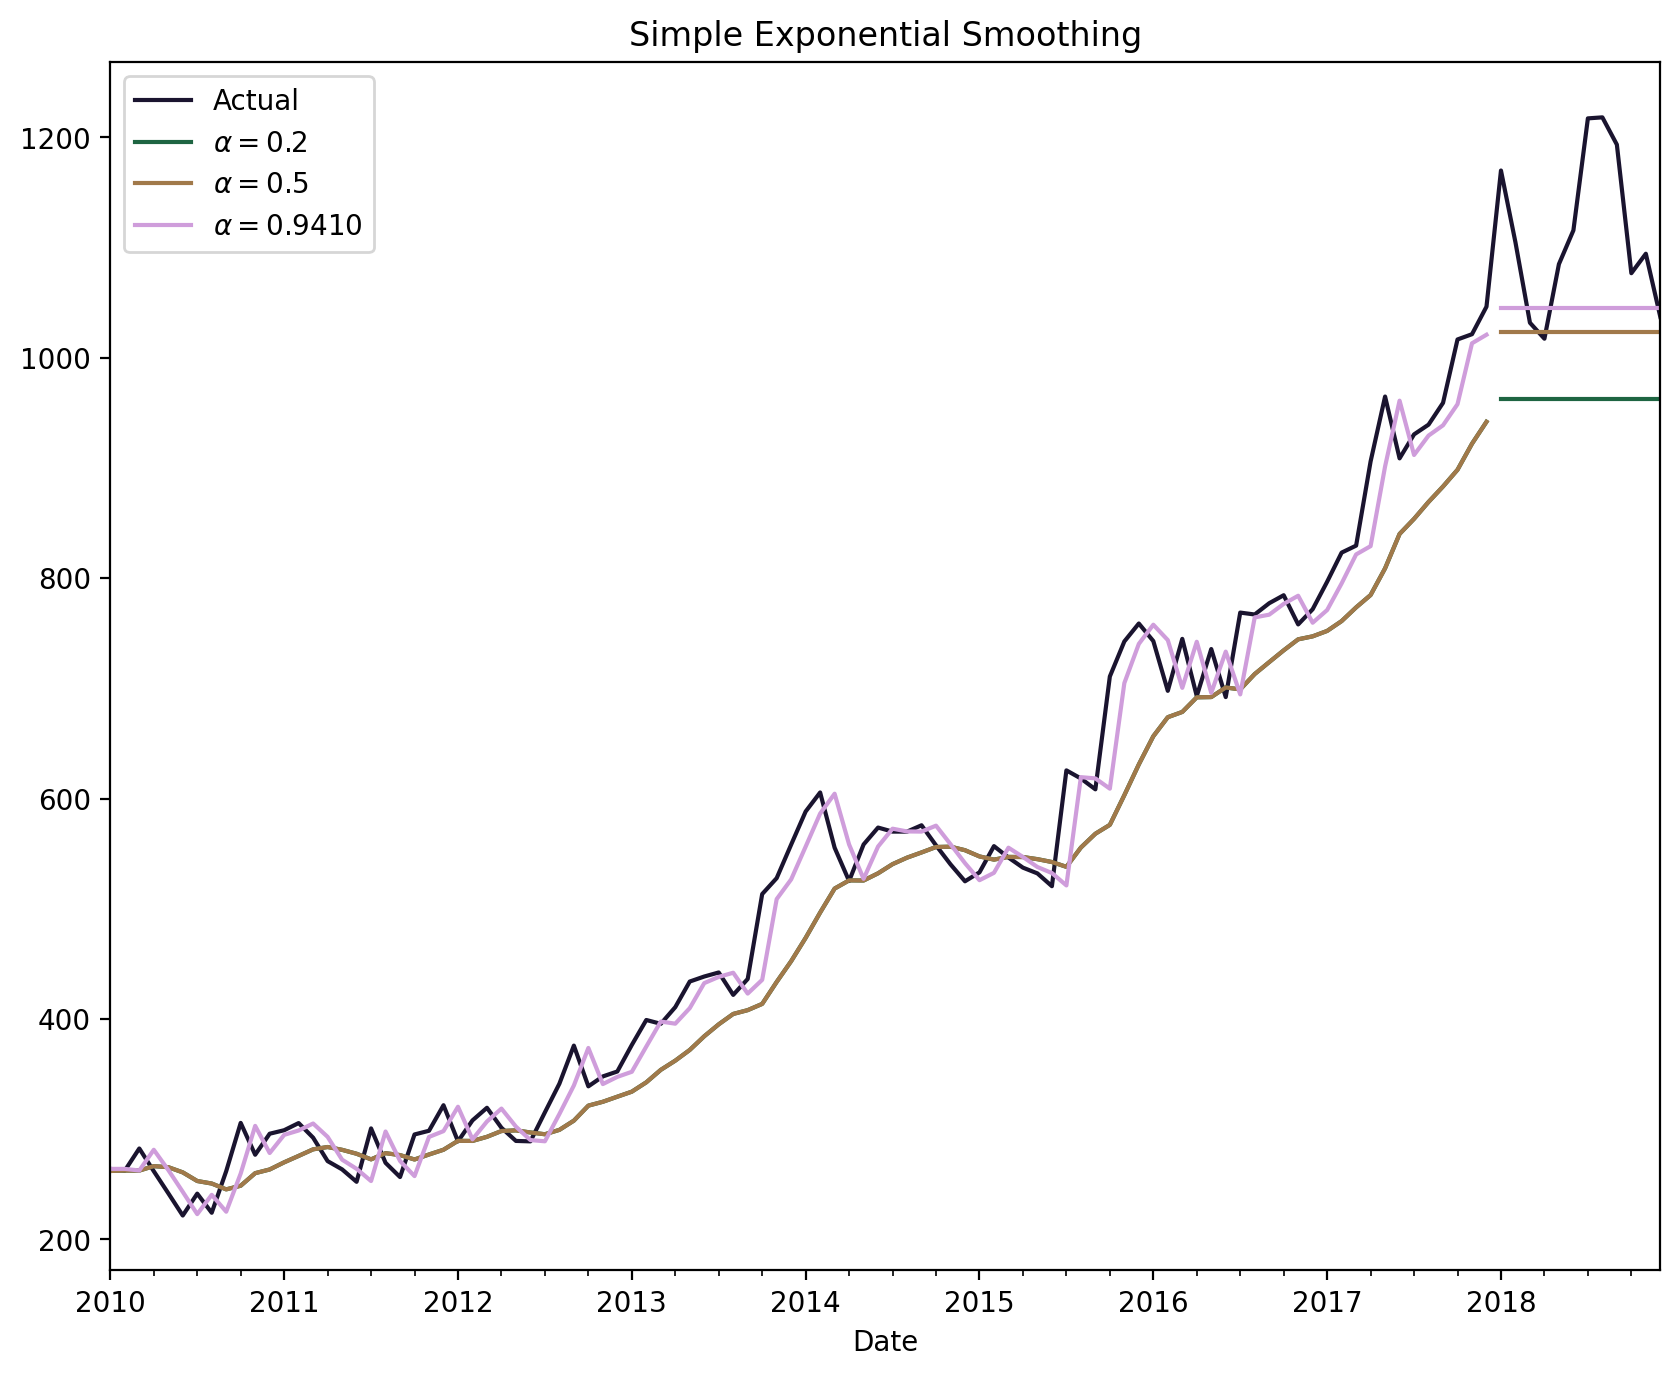

In [ ]:
goog.plot(color = COLORS[0], title = 'Simple Exponential Smoothing', label = 'Actual', legend = True)

ses_forecast_1.plot(color = COLORS[1], legend = True, label = r'$\alpha = 0.2$')
ses_1.fittedvalues.plot(color = COLORS[1])

ses_forecast_2.plot(color = COLORS[2], legend = True, label = r'$\alpha = 0.5$')
ses_1.fittedvalues.plot(color = COLORS[2])

ses_forecast_3.plot(color=COLORS[3], legend=True, label=r'$\alpha={0:.4f}$'.format(alpha))
ses_3.fittedvalues.plot(color=COLORS[3])



In [ ]:
#Holt's Model with Linear Trend
hs_1 = Holt(goog_train).fit()
hs_forecast_1 = hs_1.forecast(test_length)

#Holt's Model with Exponential Trend
hs_2 = Holt(goog_train, exponential = True).fit()
hs_forecast_2 = hs_2.forecast(test_length)

#Holt's Model with Exponential Trend and Damping
hs_3 = Holt(goog_train, exponential = True, damped = True).fit(damping_slope = 0.99)
hs_forecast_3 = hs_3.forecast(test_length)

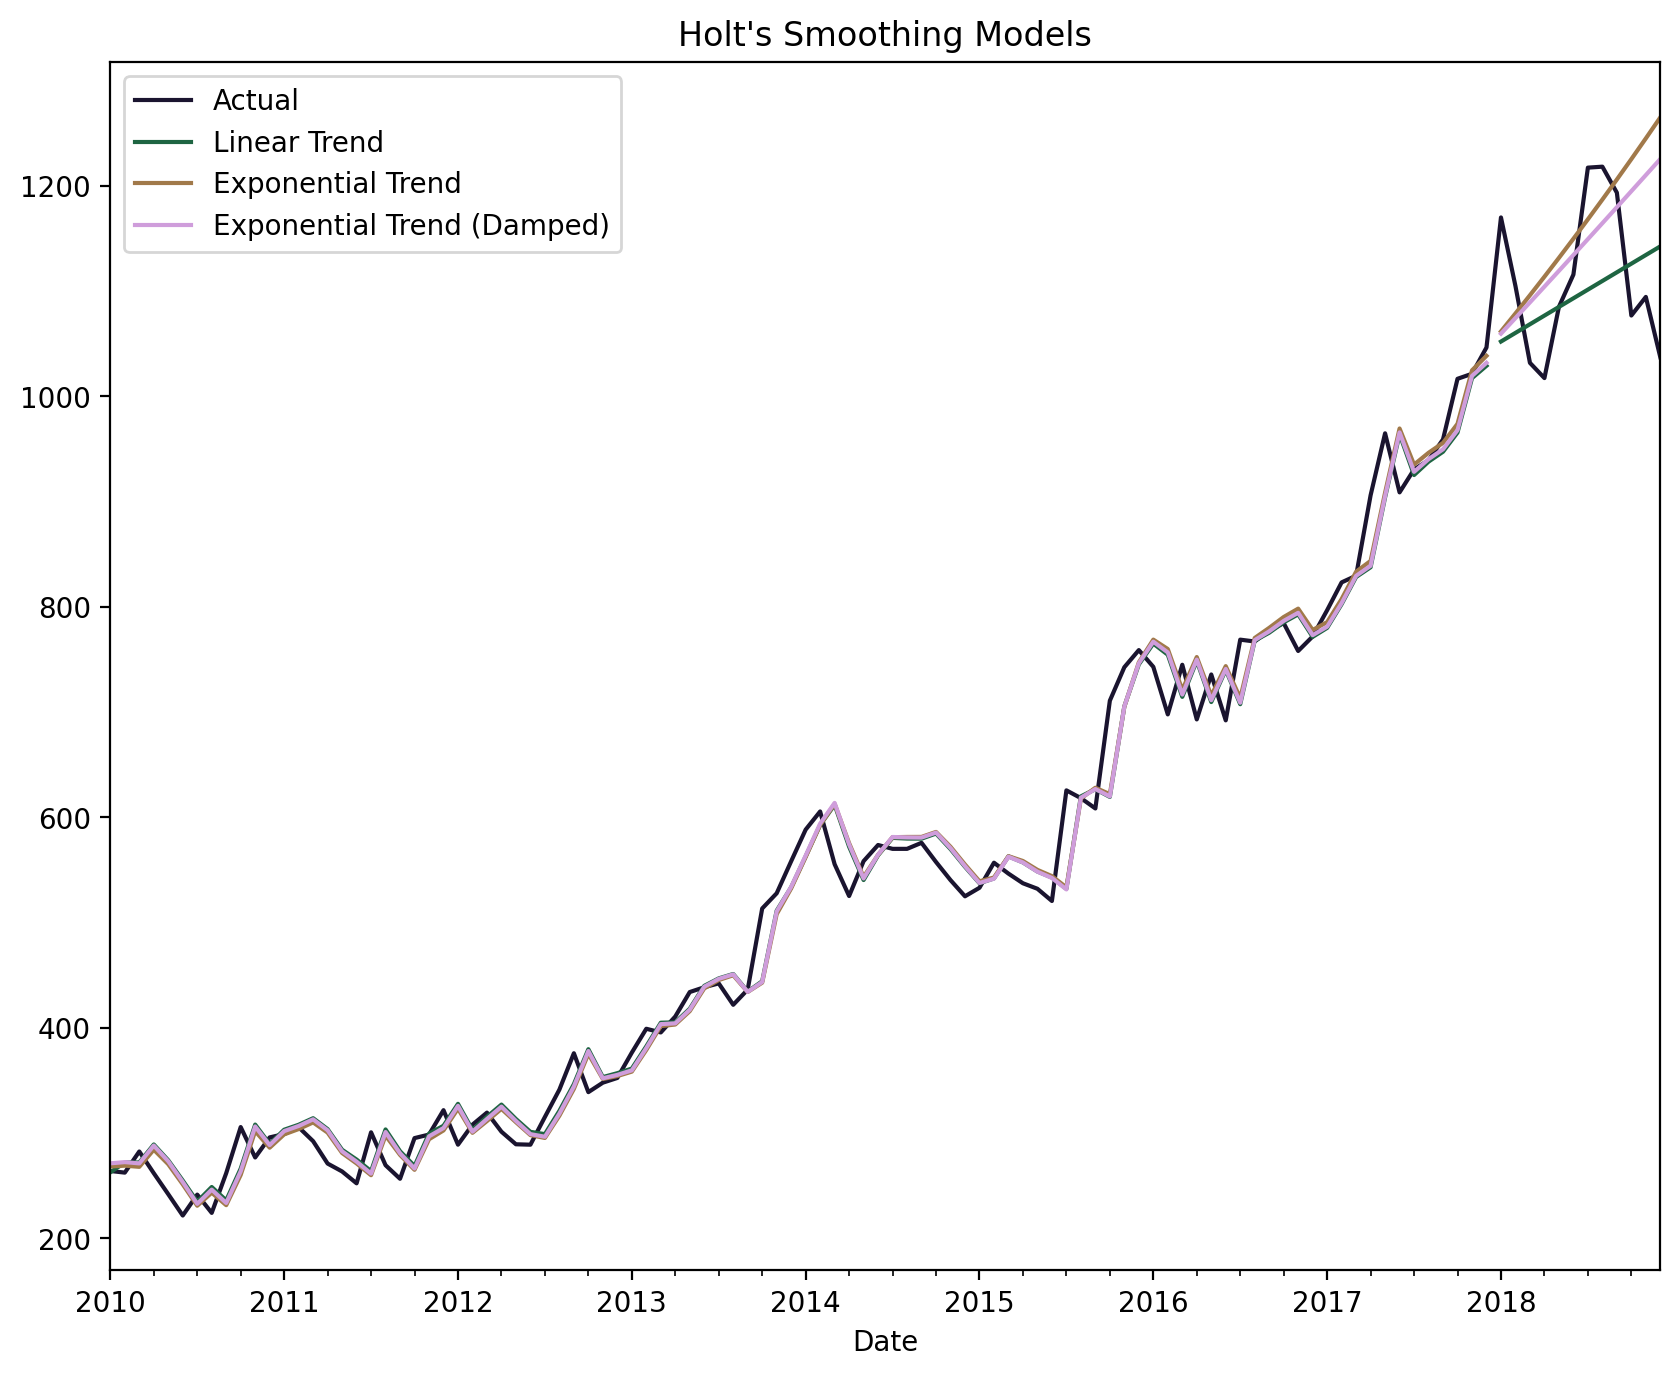

In [ ]:
goog.plot(color = COLORS[0], title = "Holt's Smoothing Models", label = 'Actual', legend = True)

hs_1.fittedvalues.plot(color = COLORS[1])
hs_forecast_1.plot(color = COLORS[1], legend = True, label = 'Linear Trend')

hs_2.fittedvalues.plot(color = COLORS[2])
hs_forecast_2.plot(color = COLORS[2], legend = True, label = 'Exponential Trend')

hs_3.fittedvalues.plot(color = COLORS[3])
hs_forecast_3.plot(color = COLORS[3], legend = True, label = 'Exponential Trend (Damped)')

In [ ]:
SEASONAL_PERIODS = 12
#Holt-Winters Model with Exponential Trend
hw_1 = ExponentialSmoothing(goog_train, trend = 'mul', seasonal = 'add', seasonal_periods = SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(test_length)

#Holt-Winters Model with Exponential Trend and Damping
hw_2 = ExponentialSmoothing(goog_train, trend = 'mul', seasonal = 'add', seasonal_periods = SEASONAL_PERIODS, damped = True).fit()
hw_forecast_2 = hw_2.forecast(test_length)

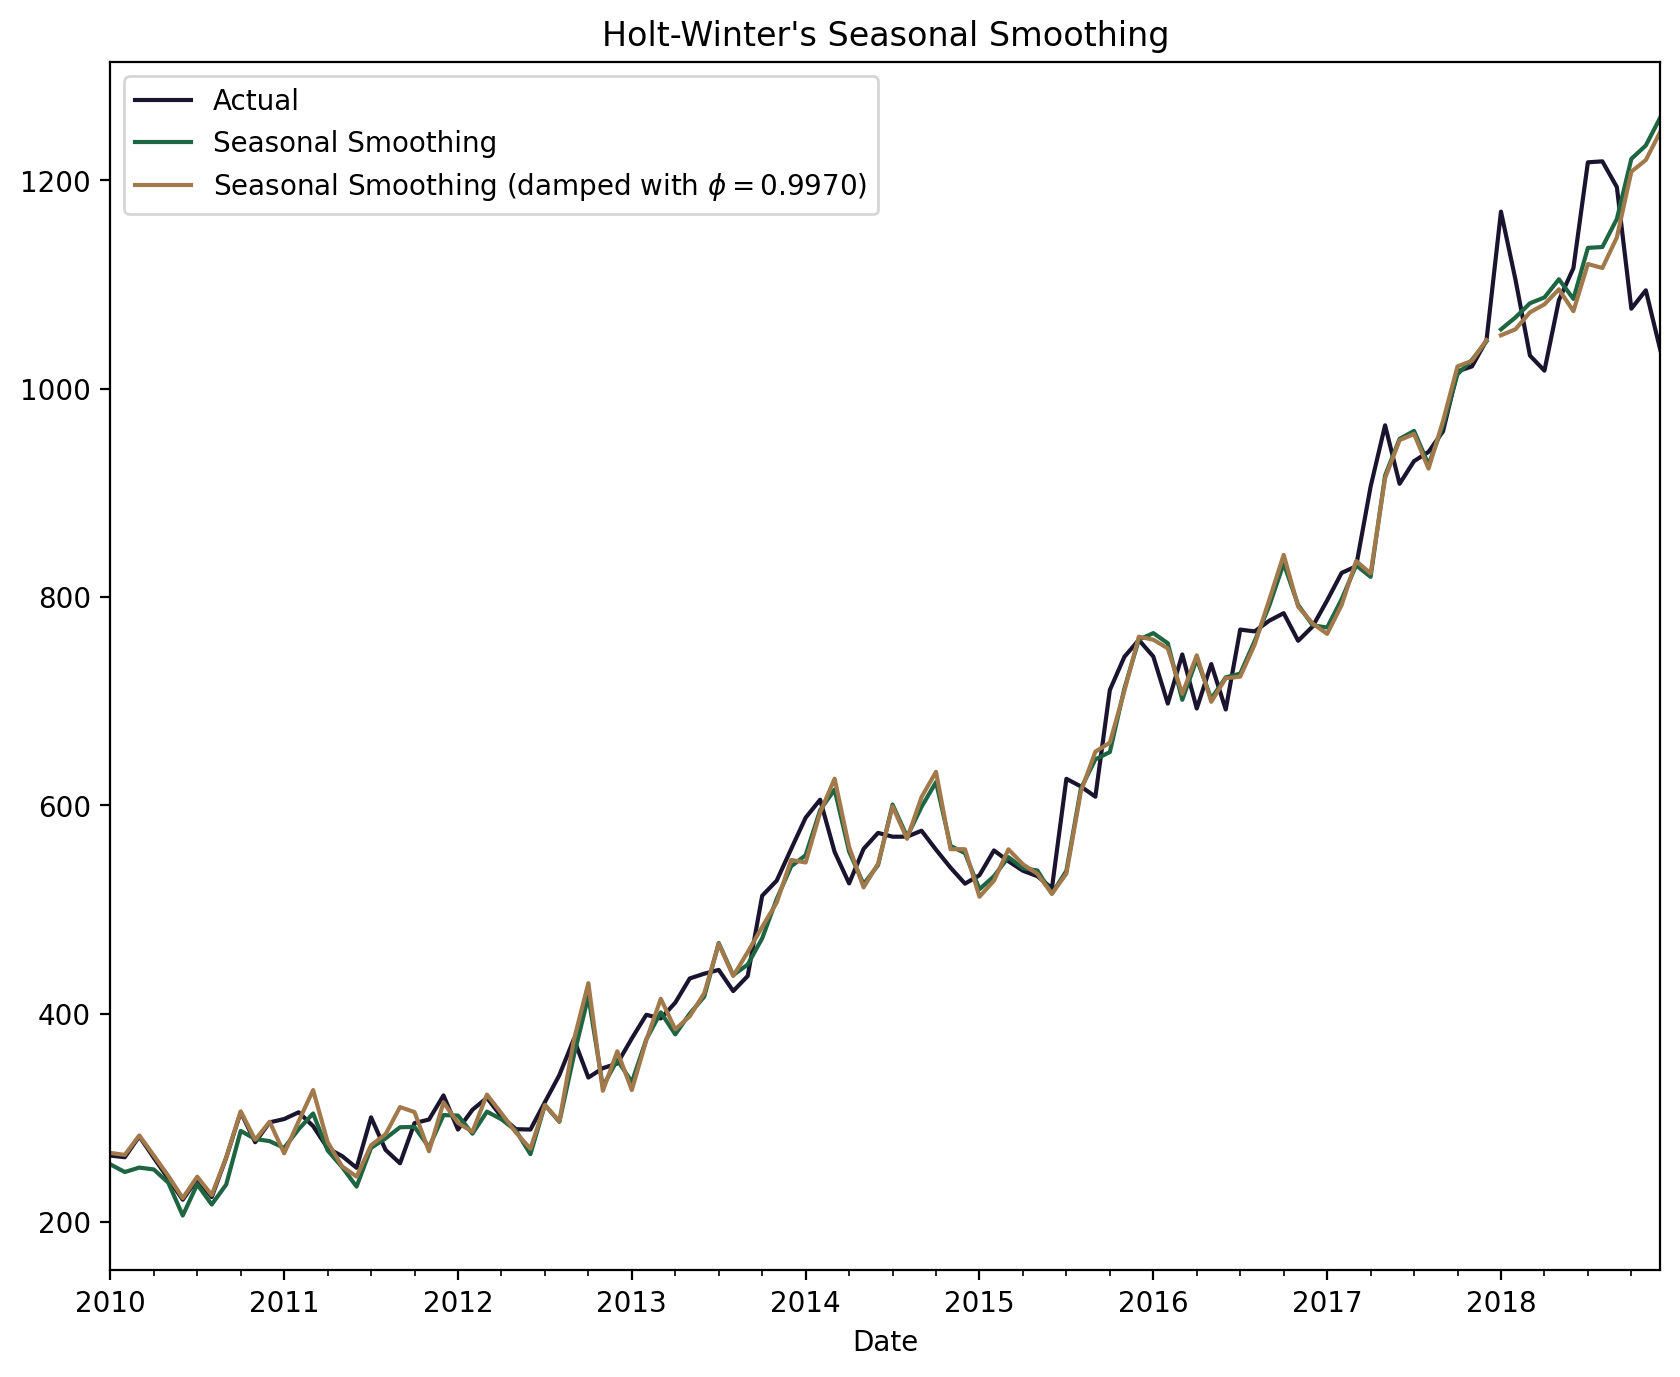

In [ ]:
goog.plot(color=COLORS[0], title="Holt-Winter's Seasonal Smoothing", label='Actual', legend=True)

hw_1.fittedvalues.plot(color=COLORS[1])
hw_forecast_1.plot(color=COLORS[1], legend=True, label='Seasonal Smoothing')

phi = hw_2.model.params['damping_slope']
plot_label = f'Seasonal Smoothing (damped with $\phi={phi:.4f}$)'

hw_2.fittedvalues.plot(color=COLORS[2])
hw_forecast_2.plot(color=COLORS[2], legend=True, label=plot_label)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs

In [ ]:
df = yf.download('GOOG', start = '2015-01-01', end = '2018-12-31', adjusted = True, progress = False)
goog = df.resample('W').last().rename(columns = {'Adj Close':'adj_close'}).adj_close

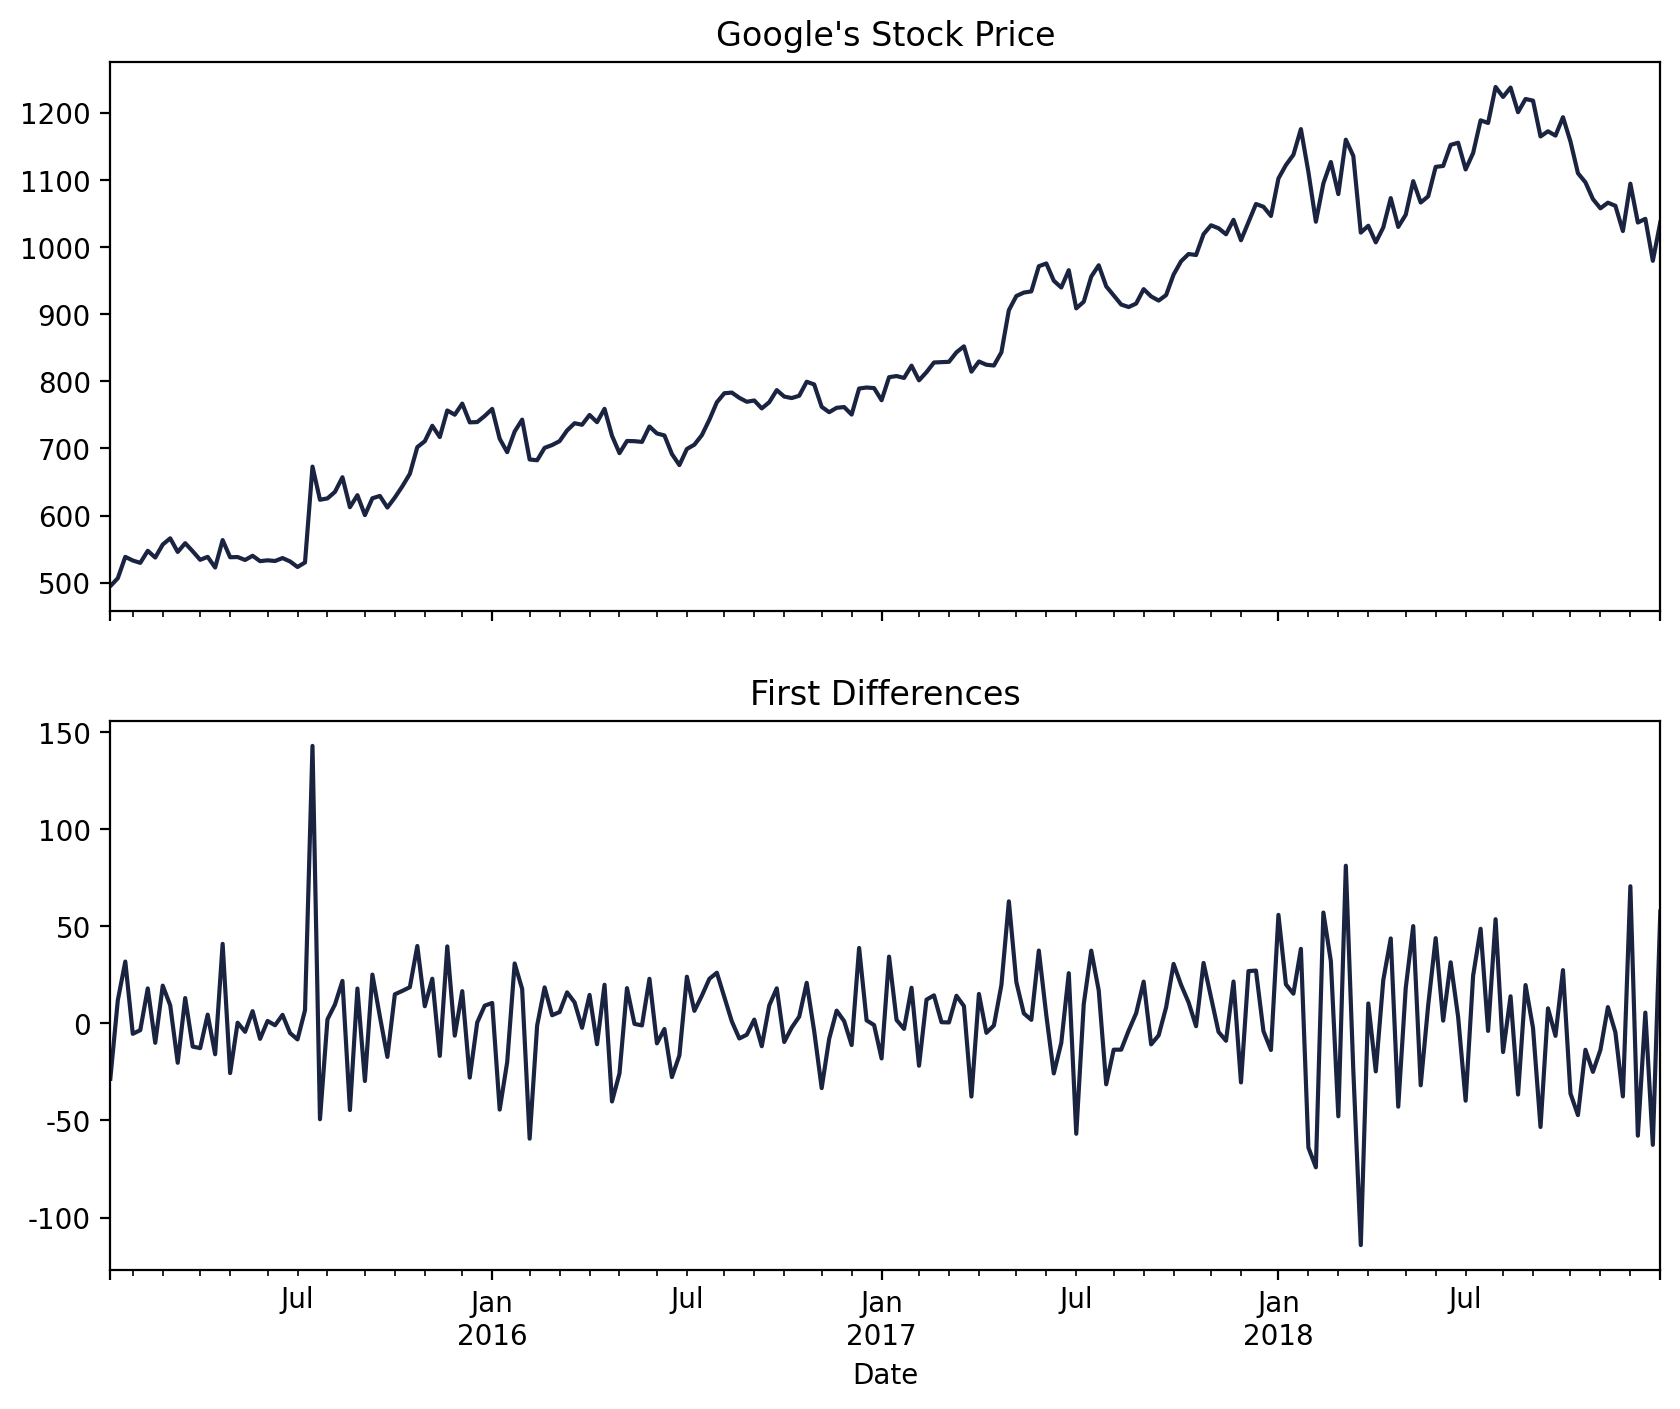

In [ ]:
goog_diff = goog.diff().dropna()

fig, ax = plt.subplots(2, sharex = True)
goog.plot(title = "Google's Stock Price", ax = ax[0])
goog_diff.plot(ax = ax[1], title = 'First Differences')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


ADF test statistic: -12.79 (p-val: 0.00)
KPSS test statistic: 0.11 (p-val: 0.10)


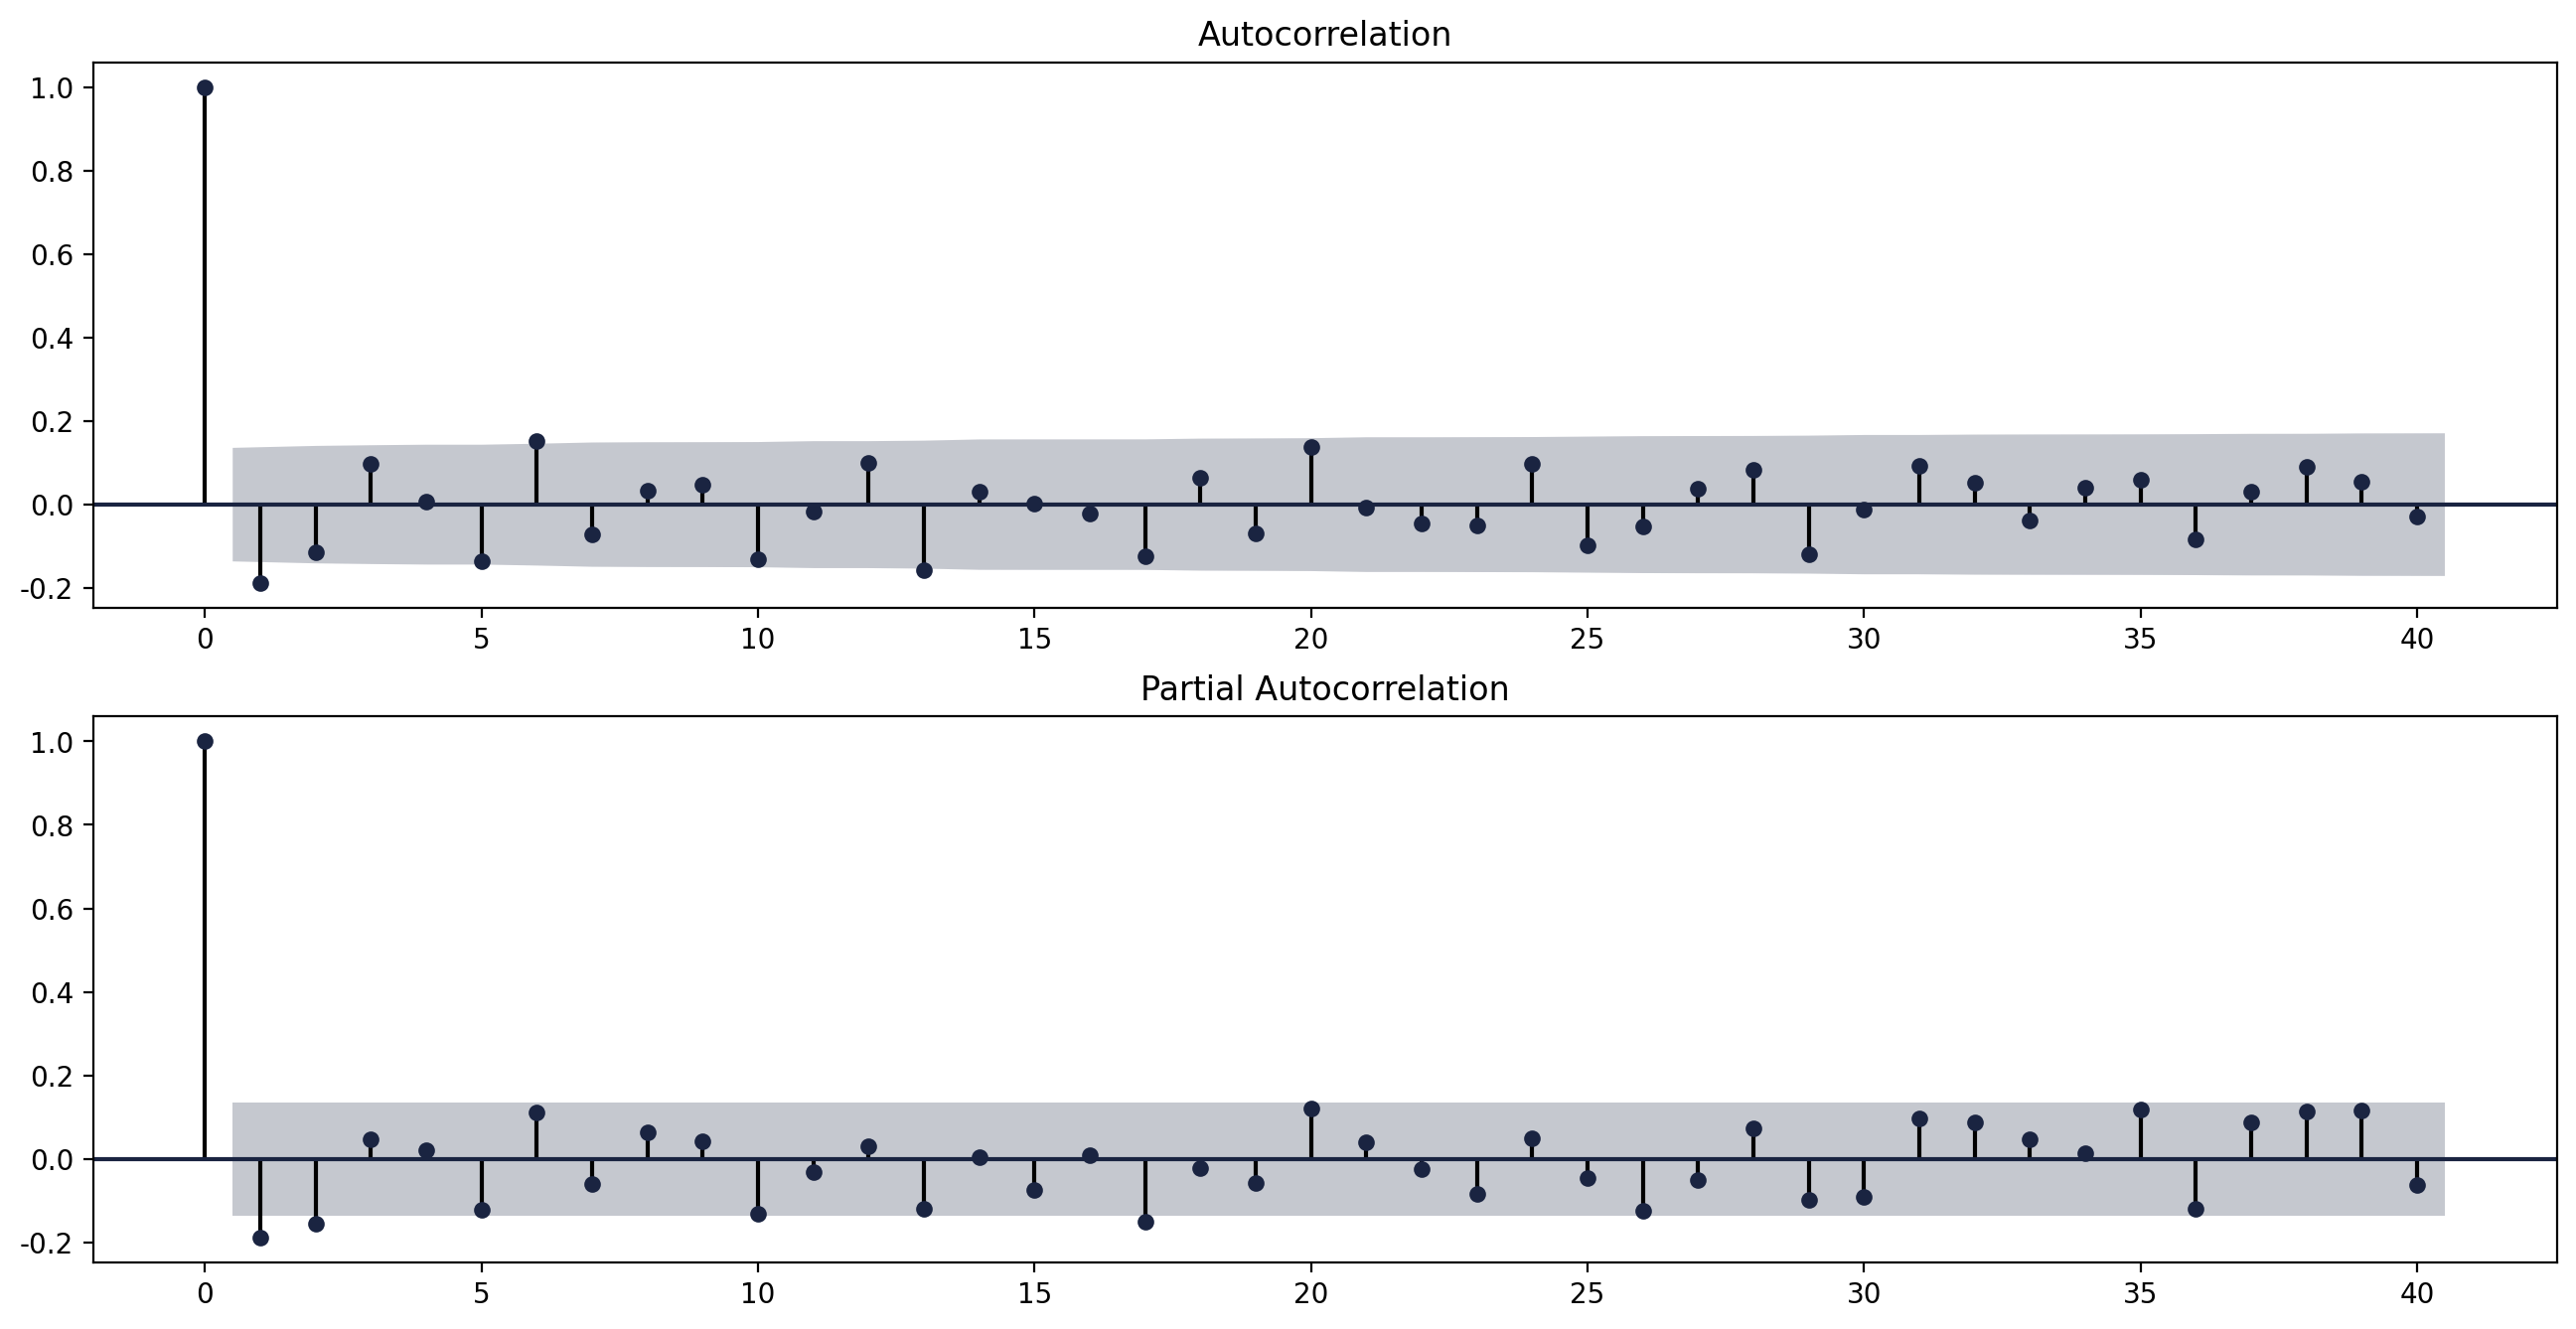

In [ ]:
test_autocorrelation(goog_diff);

In [ ]:
arima = ARIMA(goog, order = (2,1,1)).fit(disp = 0)
print(arima.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.adj_close   No. Observations:                  208
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -987.233
Method:                       css-mle   S.D. of innovations             27.859
Date:                Thu, 26 May 2022   AIC                           1984.466
Time:                        13:22:17   BIC                           2001.154
Sample:                    01-11-2015   HQIC                          1991.214
                         - 12-30-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.4700      1.441      1.714      0.088      -0.354       5.294
ar.L1.D.adj_close    -0.3908      0.280     -1.398      0.164      -0.939       0.157
ar.L2.D.adj_close    -0.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


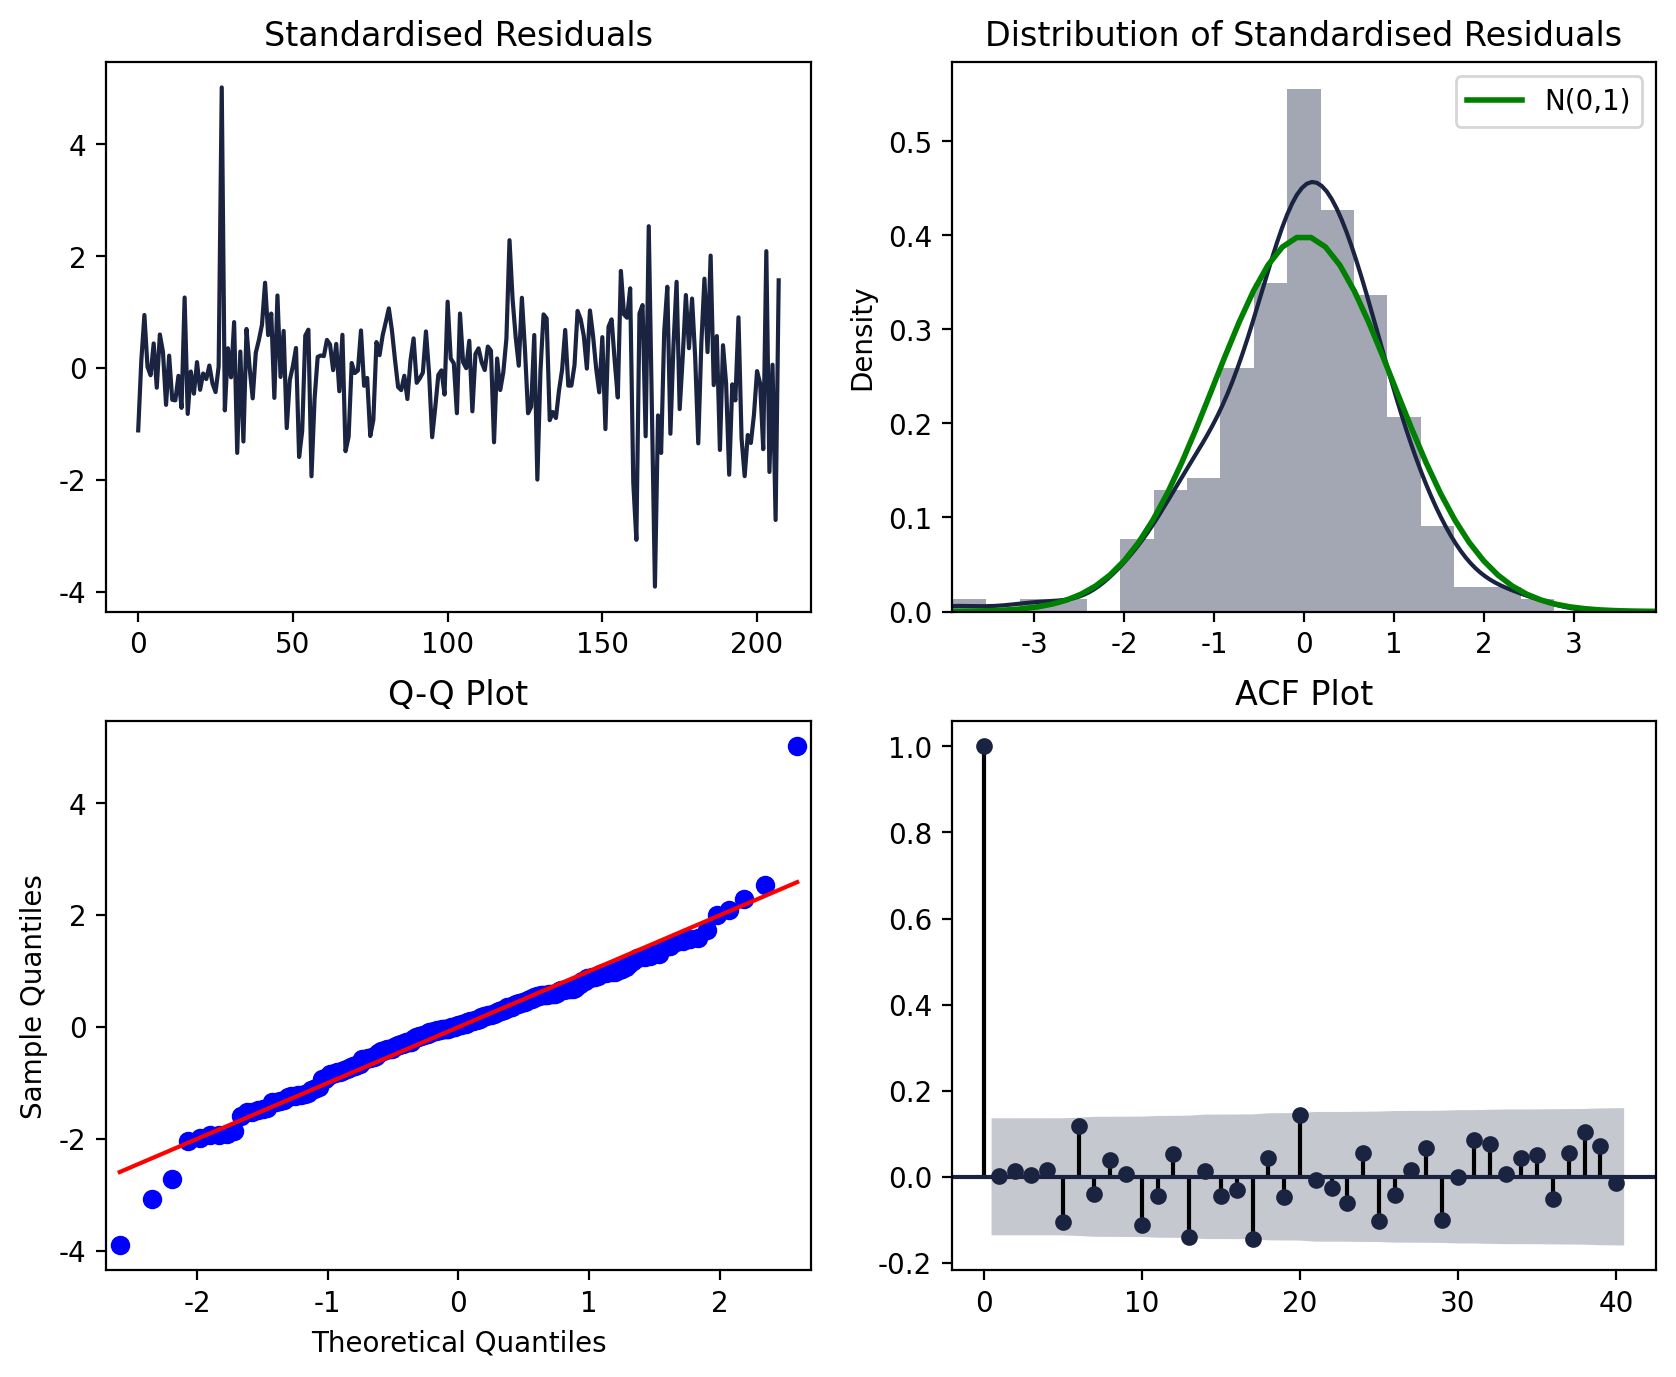

In [ ]:
def arima_diagnostics(resids, n_lags = 40):
  # Create Placeholder Subplots
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

  r = resids
  resids = (r - np.nanmean(r)) / np.nanstd(r)
  resids_nonmissing = resids[~(np.isnan(resids))]

  #Residuals over Time
  sns.lineplot(x = np.arange(len(resids)), y = resids, ax =ax1)
  ax1.set_title('Standardised Residuals')

  #Distribution of Residuals
  x_lim = (-1.96 * 2, 1.96 * 2)
  r_range = np.linspace(x_lim[0], x_lim[1])
  norm_pdf = scs.norm.pdf(r_range)
  sns.distplot(resids_nonmissing, hist = True, kde = True, norm_hist = True, ax = ax2)
  ax2.plot(r_range, norm_pdf,'g', lw = 2, label = 'N(0,1)')
  ax2.set_title('Distribution of Standardised Residuals')
  ax2.set_xlim(x_lim)
  ax2.legend()

  #Q-Q Plot
  qq = sm.qqplot(resids_nonmissing, line = 's', ax = ax3)
  ax3.set_title('Q-Q Plot')
  
  #ACF Plot
  plot_acf(resids, ax= ax4, lags = n_lags, alpha = 0.05)
  ax4.set_title('ACF Plot')

  return fig

arima_diagnostics(arima.resid, 40);


[Text(0, 0.5, 'p-value'),
 Text(0.5, 0, 'Lag'),
 Text(0.5, 1.0, "Ljung-Box test's results")]

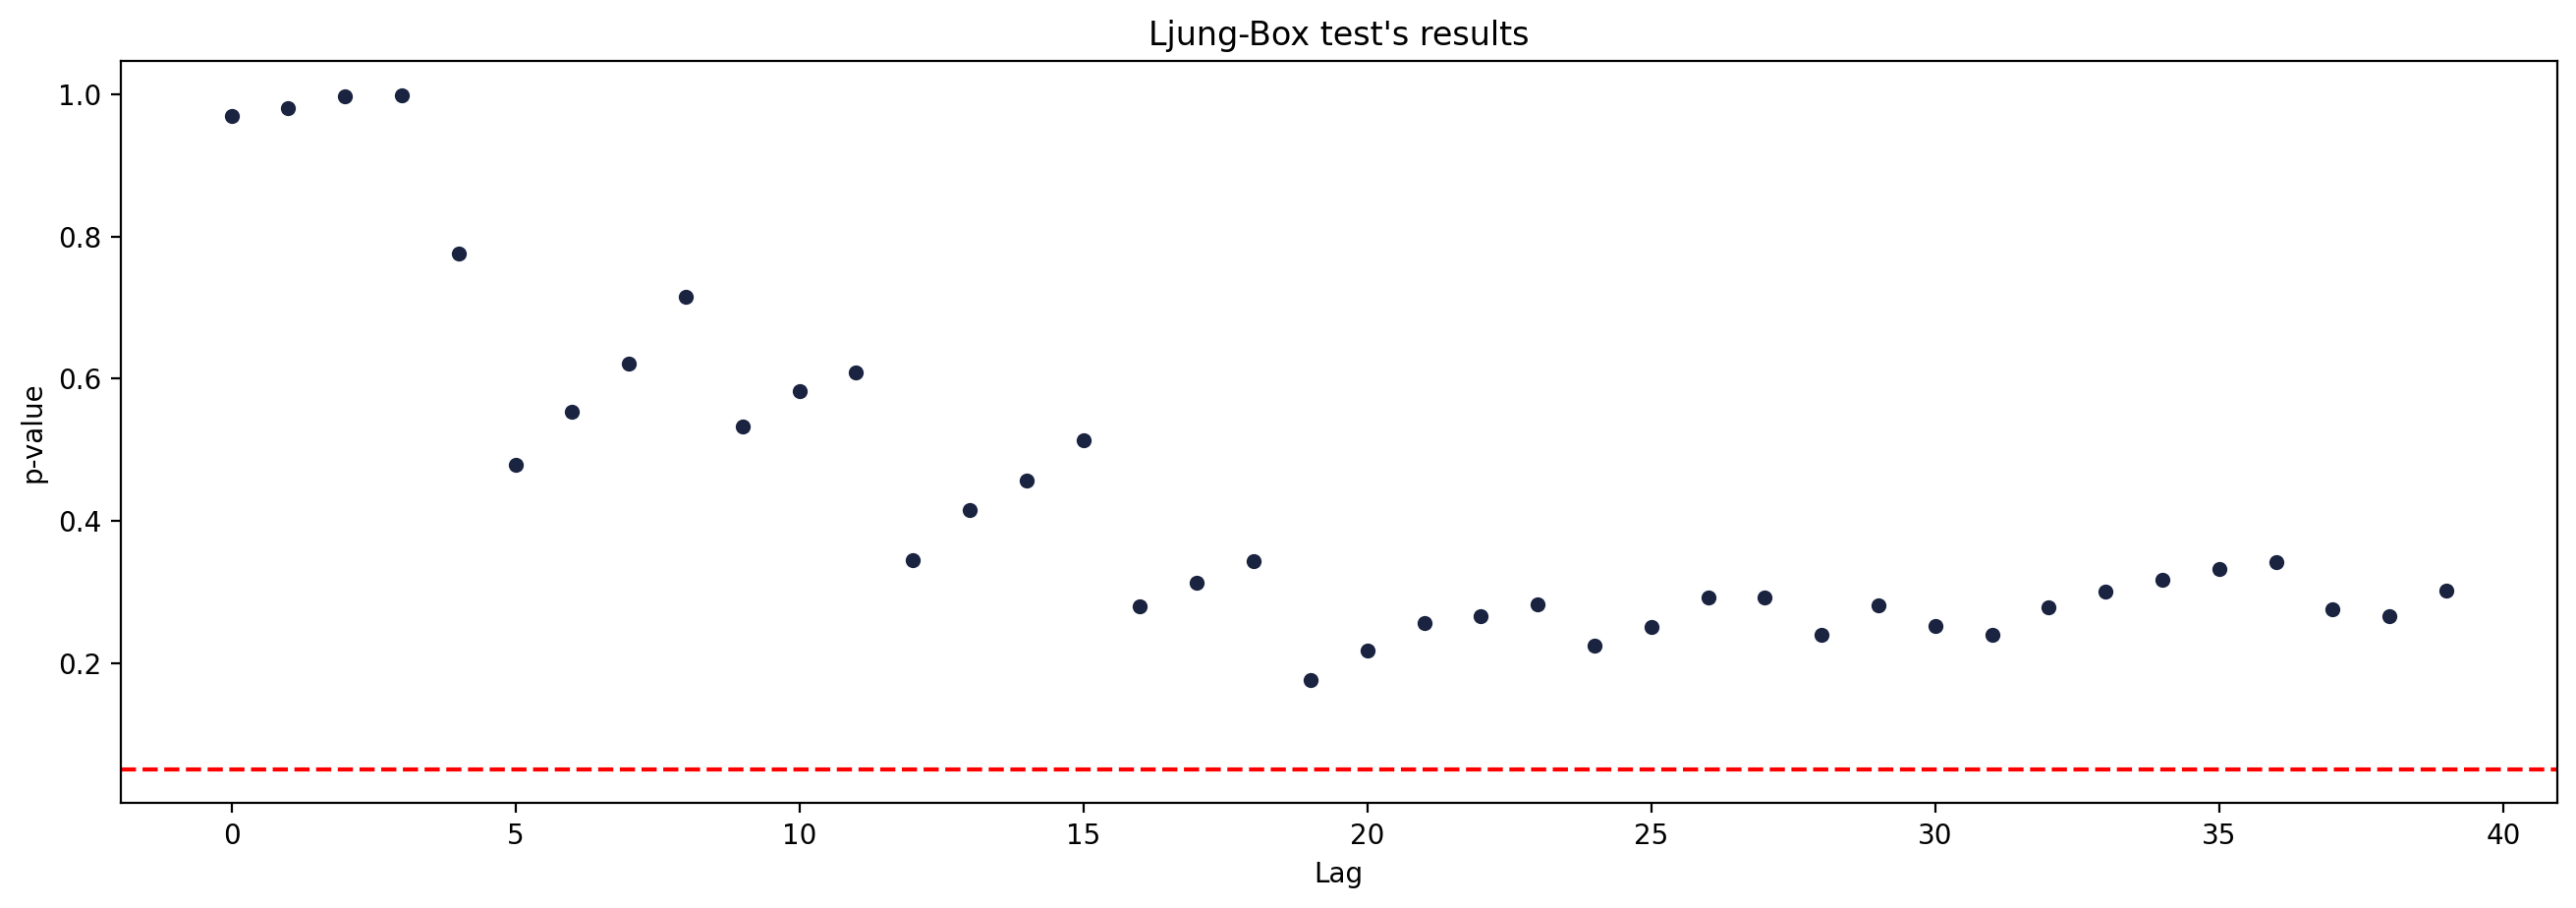

In [ ]:
ljung_box_results = acorr_ljungbox(arima.resid)

fig, ax = plt.subplots(1, figsize = [16,5])
sns.scatterplot(x = range(len(ljung_box_results[1])), y = ljung_box_results[1], ax =ax )

ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results", xlabel='Lag', ylabel='p-value')


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pmdarima as pm
auto_arima = pm.auto_arima(goog, error_action = 'ignore', suppress_warnings = True, seasonal = False,stepwise = False, approximation = False, n_jobs = 1)
print(auto_arima.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  209
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -982.693
Date:                Thu, 26 May 2022   AIC                           1979.386
Time:                        13:22:33   BIC                           2002.749
Sample:                             0   HQIC                          1988.833
                                - 209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.9537      6.251      1.592      0.111      -2.298      22.205
ar.L1         -1.5446      0.138    -11.213      0.000      -1.815      -1.275
ar.L2         -1.1845      0.137     -8.623      0.0

In [ ]:
df = yf.download('GOOG', start='2019-01-01', end='2019-03-31', adjusted=True, progress=False)
test = df.resample('W').last().rename(columns={'Adj Close': 'adj_close'}).adj_close

In [ ]:
n_forecasts = len(test)
arima_pred = arima.forecast(n_forecasts)
arima_pred = [pd.DataFrame(arima_pred[0], columns = ['prediction']), pd.DataFrame(arima_pred[2], columns = ['ci_lower','ci_upper'])]
arima_pred = pd.concat(arima_pred, axis = 1).set_index(test.index)
arima_pred

,prediction,ci_lower,ci_upper
Date,,,
2019-01-06,1038.227729,983.624837,1092.830621
2019-01-13,1030.697249,961.205632,1100.188867
2019-01-20,1037.328361,958.554816,1116.101907
2019-01-27,1040.081908,950.990770,1129.173045
2019-02-03,1041.646389,943.584449,1139.708330
2019-02-10,1044.416143,938.372447,1150.459840
2019-02-17,1046.941914,933.347310,1160.536519
2019-02-24,1049.332862,928.667190,1169.998533
2019-03-03,1051.823099,924.497405,1179.148793


In [ ]:
auto_arima_pred = auto_arima.predict(n_periods = n_forecasts, return_conf_int = True, alpha = 0.05)
auto_arima_pred = [pd.DataFrame(auto_arima_pred[0], columns = ['prediction']), pd.DataFrame(auto_arima_pred[1], columns = ['ci_lower', 'ci_upper'])]
auto_arima_pred = pd.concat(auto_arima_pred, axis = 1).set_index(test.index) 

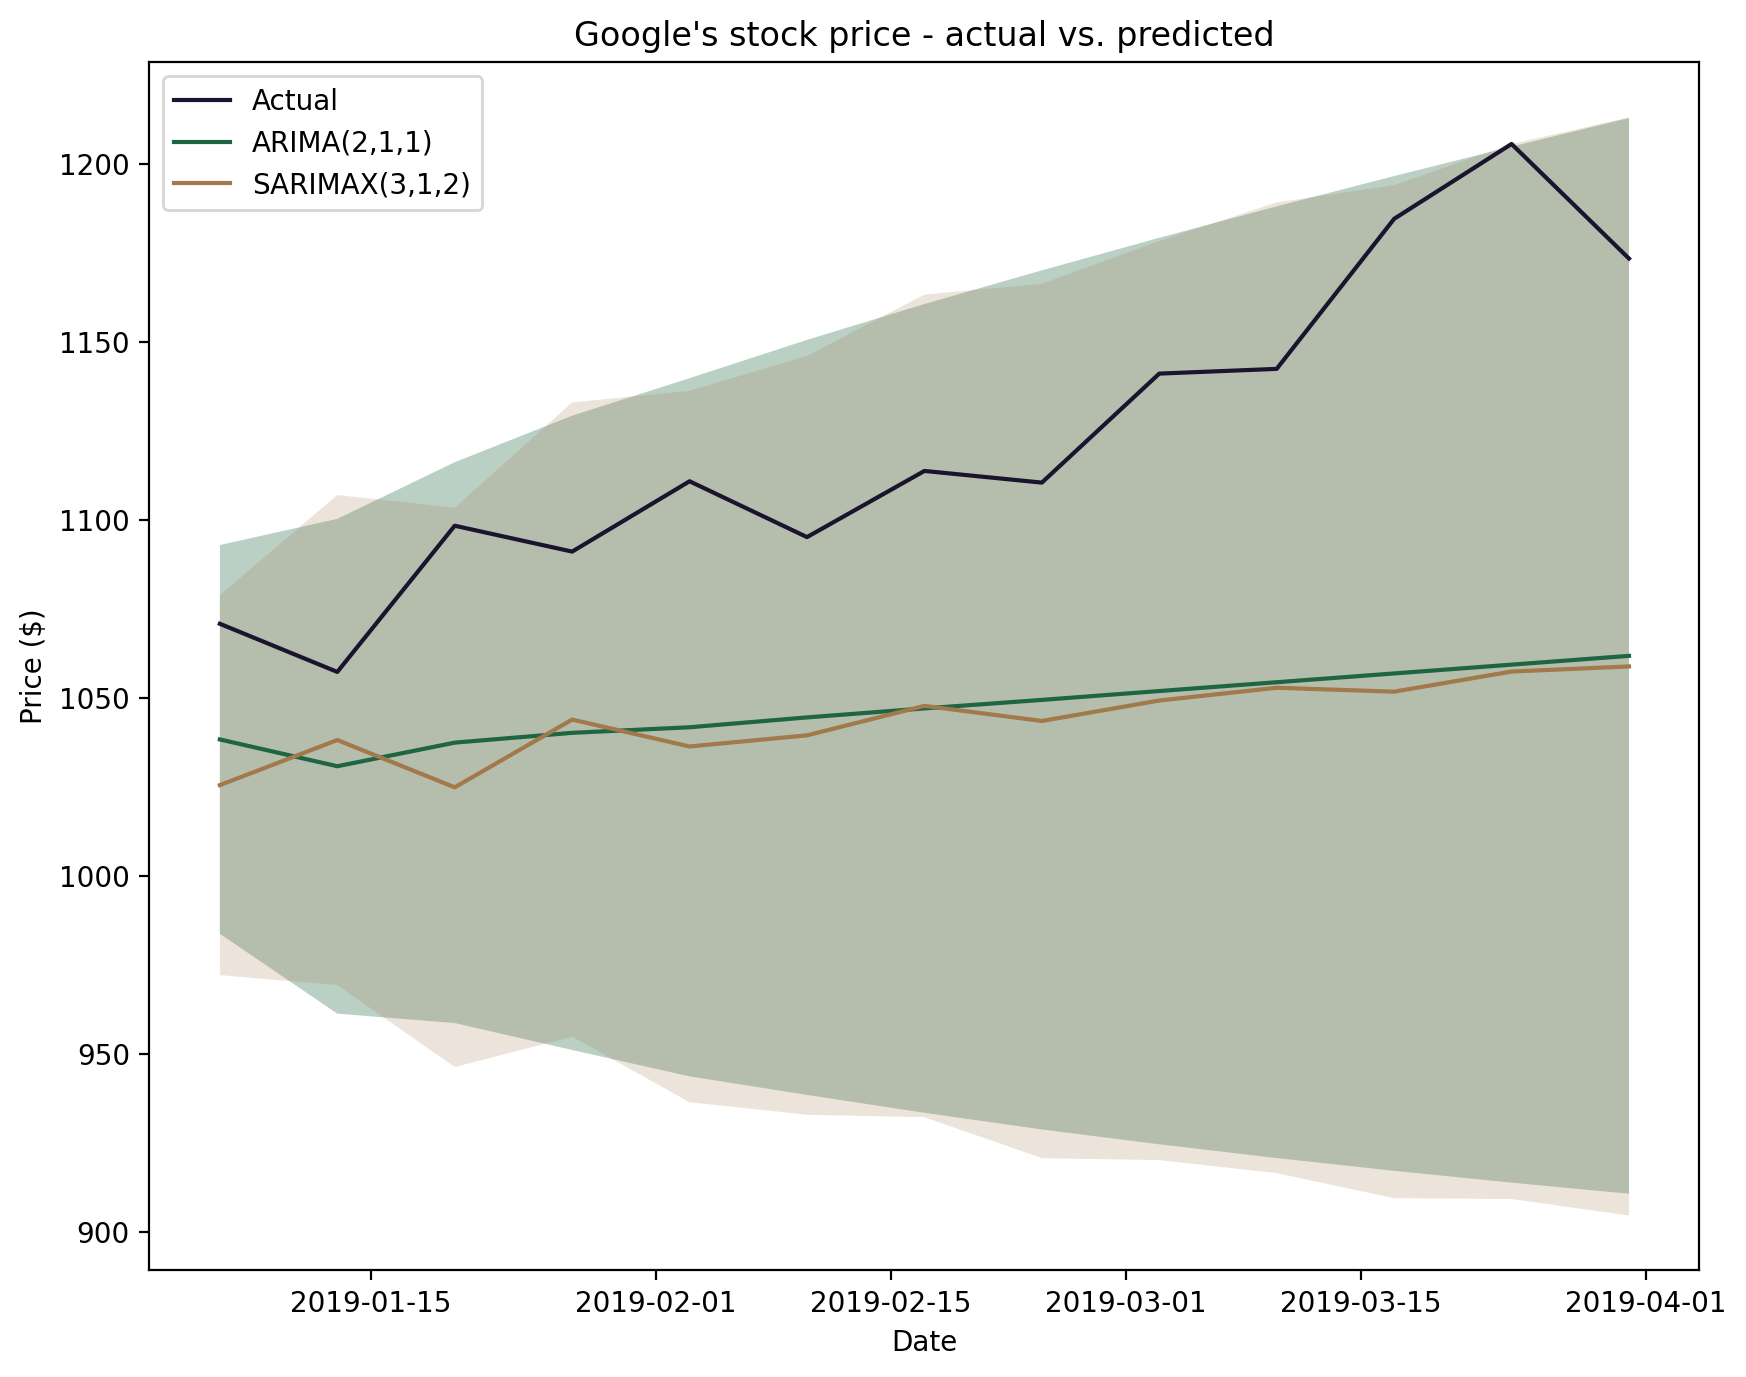

In [ ]:
fig, ax = plt.subplots(1)
ax = sns.lineplot(data=test, color=COLORS[0], label='Actual')
ax.plot(arima_pred.prediction, c=COLORS[1], label='ARIMA(2,1,1)')
ax.fill_between(arima_pred.index,arima_pred.ci_lower, arima_pred.ci_upper, alpha=0.3, facecolor=COLORS[1])
ax.plot(auto_arima_pred.prediction, c=COLORS[2], label='SARIMAX(3,1,2)')
ax.fill_between(auto_arima_pred.index, auto_arima_pred.ci_lower, auto_arima_pred.ci_upper, alpha=0.2, facecolor=COLORS[2])
ax.set(title="Google's stock price - actual vs. predicted", xlabel='Date', ylabel='Price ($)')
ax.legend(loc='upper left')
